# This notebook is for finding latest active addresses (and their selected token pairs) in pancakeswap. 

In [1]:
import pandas as pd
import math
import requests
import json
import numpy as np
import webbrowser
import time

from web3 import Web3
from web3.middleware import geth_poa_middleware

from hexbytes import HexBytes as hb
pd.set_option('display.max_columns', 500)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

%load_ext autoreload
%autoreload 2
from functions import * # most functions are kept there for convenience
bsc_scan_api_key = "ID63Y14WNZY1NTAP8DEHN28KTC4NZAVHM4"

binance_provider = 'https://bsc-dataseed.binance.org' 
w3 = Web3(Web3.HTTPProvider(binance_provider))



pair_address="0xb5d7cc509f9de98e35f054392666122fdd4def47" # token_names = {"token0":"DARK","token1":"BUSD"}
#  information about the pair
abi = get_bsc_contract_abi(bsc_scan_api_key, pair_address) # gets an abi for the pair contract - it is universal for pancakeswap at least
token_abi = get_bsc_contract_abi(bsc_scan_api_key, "0x55d398326f99059fF775485246999027B3197955") # get a generic token abi to be able to read token contract symbol
pair_info = get_pair_info(pair_address,abi,bsc_scan_api_key,w3,token_abi) # get pair info
# need this only to parse Swap data using abi event signatures 
signatures = get_signatures_from_abi(abi) # extracts signatures of events in abi - it is universal for pancakeswap at least

pair_info["signatures"] = signatures

## Get the latest transactions in pancake_swap from bsc_scan_api
##### (seems much faster than using web3)

In [2]:
# write hours that you want to scrape
scrape_last_hours = 10
# BSC blocks are once every 3 seconds
blocks_every_n_seconds = 3

blocks_ago = scrape_last_hours*60*60//3
results=get_bsc_historical_pancake_swaps(fromBlock=w3.eth.blockNumber-blocks_ago, toBlock=w3.eth.blockNumber, bsc_scan_api_key=bsc_scan_api_key)

getting BSC Historical Logs from block 23162342 to block 23174342...
Found 1000 txs from 23162342 block to 23162376 block.
Found 1000 txs from 23162376 block to 23162412 block.
Found 1000 txs from 23162412 block to 23162435 block.
Found 1000 txs from 23162435 block to 23162468 block.
Found 1000 txs from 23162468 block to 23162498 block.
Found 1000 txs from 23162498 block to 23162531 block.
Found 1000 txs from 23162531 block to 23162565 block.
Found 1000 txs from 23162565 block to 23162605 block.
Found 1000 txs from 23162605 block to 23162640 block.
Found 1000 txs from 23162640 block to 23162673 block.
Found 1000 txs from 23162673 block to 23162705 block.
Found 1000 txs from 23162705 block to 23162737 block.
Found 1000 txs from 23162737 block to 23162773 block.
Found 1000 txs from 23162773 block to 23162811 block.
Found 1000 txs from 23162811 block to 23162855 block.
Found 1000 txs from 23162855 block to 23162901 block.
Found 1000 txs from 23162901 block to 23162943 block.
Found 1000 tx

## Crude analysis and filtering of addresses 

In [3]:
# FILTER OUT AND ANALYSE ACTIVE ADDRESSES

df = pd.DataFrame(results) # turn the list of dictionary to pandas dataframe
df = parse_results_dataframe(df,pair_info) # parse the tx info 

# drop Swap receivers that are known token addresses or token pairs. 

# swapping_contracts=[
#     "0x10ed43c718714eb63d5aa57b78b54704e256024e", # PancakeSwap: Router v2 contract address 
#     "0x7efaef62fddcca950418312c6c91aef321375a00", # Pancake LPs (Cake-LP)
#     "0x16b9a82891338f9ba80e2d6970fdda79d1eb0dae", # USDT/WBNB
#     "0x58f876857a02d6762e0101bb5c46a8c1ed44dc16", # WBNB/USDT
#     "0x804678fa97d91b974ec2af3c843270886528a9e6", # Cake/BUSD
#     "0x0ed7e52944161450477ee417de9cd3a859b14fd0", # Cake/WBNB
#     "0x90c7c04457f3649a50bcbfa5a6b0711dd093b5ce", # WBNB/DW2
#     "0xbb6e2f4f94c2f5907379f0675a92a0c20c1bed31", # WBNB/ToolDOGE
#     "0x804678fa97d91b974ec2af3c843270886528a9e6", # Cake/BUSD
# ] # it is endless
swapping_contracts = list(set(df.contract_address)) + [
    "0x10ed43c718714eb63d5aa57b78b54704e256024e",# PancakeSwap: Router v2 contract address 
    "0x000000000000000000000000000000000000dead",# null address for token burning
] 
df = df[~df['To'].isin(swapping_contracts)] # drop swaps that contain these addresses as to. Only can contain (and will contain) as From for simple swaps

hour_window = (df.timeStamp.max() - df.timeStamp.min()) / (60*60)
print(f"Table contains {len(df)} txs from {df.DateTime.min()} to {df.DateTime.max()}, which is {round(hour_window,2)} hour window")


# Crude analysis of every address: txs_from_address, percent_txs_from_address
all_swaps=df[df.event == "Swap"]

# Select a treshold of swaps that need to be made by any single address to stay in dataframe
all_swaps = keep_active_adresses(all_swaps = all_swaps, at_least_swaps = 5) # rapidly filters out the majority of adresses that had very few swaps

# get percent fraction of txs made by this address compared to all txs
all_swappers = set(all_swaps.dropna(subset=["To"]).To.to_list())
all_swappers.discard(pair_address)
all_swappers.discard("0x0000000000000000000000000000000000000000")
iteration=0
total_token1_volume_by_all_addresses = (all_swaps["amount1In"].sum() + all_swaps["amount1Out"].sum())
total_token0_volume_by_all_addresses = (all_swaps["amount0In"].sum() + all_swaps["amount0Out"].sum())
analyzed_swaps = pd.DataFrame()
for address in list(all_swappers):
    # print(address)
    address_swaps= all_swaps[(all_swaps.To == address)].copy()
    if len(address_swaps)<4:
        # print("skipping")
        continue
    iteration+=1
    print(f"Analysing address {iteration} out of {len(list(all_swappers))}", end = "\r")
    address_swaps["txs_from_address"] = len(address_swaps)
    address_swaps["percent_txs_from_address"] = round((len(address_swaps)/len(all_swaps)*100), 4)  # len(txs) / len(swaps) * 100%

    # find sandwitch bots: quick way: check how many txs were in the same block
    # address_swaps["txs_in_same_block"] = len(set(address_swaps.transactionHash)) - len(set(address_swaps.drop_duplicates("transactionHash").blockNumber))
    most_common_pair_address = max(set(address_swaps.contract_address.to_list()), key = address_swaps.contract_address.to_list().count) 
    address_swaps["most_common_pair_address"] = most_common_pair_address
    address_swaps["focused_on_single_pair"] = (len(set(address_swaps.contract_address.to_list())) == 1)

    # measure volume
    total_amount1Out_by_address = sum(address_swaps["amount1Out"])
    total_amount1In_by_address = sum(address_swaps["amount1In"])
    address_swaps["total_amount1Out_by_address"] = total_amount1Out_by_address # selects where to is the address and prescribes a value which is sum of this same table 
    address_swaps["total_amount1In_by_address"] = total_amount1In_by_address
    address_swaps["total_token1_volume_by_address"] = total_amount1Out_by_address + total_amount1In_by_address

    total_amount0Out_by_address = sum(address_swaps["amount0Out"])
    total_amount0In_by_address = sum(address_swaps["amount0In"])
    address_swaps["total_amount0Out_by_address"] = total_amount0Out_by_address # selects where to is the address and prescribes a value which is sum of this same table 
    address_swaps["total_amount0In_by_address"] = total_amount0In_by_address 
    address_swaps["total_token0_volume_by_address"] = total_amount0Out_by_address + total_amount0In_by_address

    # measure percent fraction of volume: (total address volume) / (total volume by all addresses) * 100
    address_swaps["percent_token1_volume_by_address"] = (total_amount1Out_by_address + total_amount1In_by_address) / total_token1_volume_by_all_addresses * 100
    address_swaps["percent_token0_volume_by_address"] = (total_amount0Out_by_address + total_amount0In_by_address) / total_token0_volume_by_all_addresses * 100
    
    # HERE FILTER OUT THE MOST COMON PAIR ADDRESS AND CONTINUE ANALYSIS
    address_swaps = address_swaps[address_swaps.contract_address == most_common_pair_address] 

    # count how many txs appear in same block
    address_swaps["txs_in_same_block"] = address_swaps.drop_duplicates("transactionHash").duplicated(subset=["contract_address", "blockNumber"]).sum()

    # Quantify if address is mostly buying, selling or both. Quantify the position in terms of buy/sell ratio 
    position_ratio = (address_swaps.amount0In.sum() + address_swaps.amount1Out.sum() + 1) / (address_swaps.amount1In.sum() + address_swaps.amount0Out.sum() + 1)
    if position_ratio < 1:
        position_ratio = 1/position_ratio
    address_swaps["position_ratio"] = position_ratio

    # Many bad market makers use same amounts of tokens for trades - quantify the similarity of these amounts to indicate crappy bot - 0 if no simmilarity, 1 if maximum similarity
    token0_ammount_similarity = 1 - (len(set(address_swaps.amount0Out + address_swaps.amount0In)) / len(address_swaps)) # 1 / (fraction unique)
    token1_ammount_similarity = 1 - (len(set(address_swaps.amount1Out + address_swaps.amount1In)) / len(address_swaps)) # 1 / (fraction unique)
    tx_size_similarity = max(token0_ammount_similarity, token1_ammount_similarity) # chose the larger one
    address_swaps["tx_size_similarity"] = tx_size_similarity

    # Calculation of profits - DOES NOT ACCOUNT FOR DECIMALS AS IT TAKES TOO LONG TO GET PAIR CONTRACT INFO. NEED TO STORE DECIMAL DATA LOCALLY
    # Get token price, which is simply a ratio of the Swap
    token0_price_in_token1 = pd.to_numeric((address_swaps.amount1In + address_swaps.amount1Out) / (address_swaps.amount0In + address_swaps.amount0Out)) #* (10**(pair_info["token0_decimals"]-pair_info["token1_decimals"])) # accounting for token decimals shown in contract
    token1_price_in_token0 = 1 / token0_price_in_token1
    # Get current accumulated position
    position_token0 = (address_swaps.amount0Out.sum() - address_swaps.amount0In.sum()) #* 10** - pair_info["token0_decimals"]
    position_token1 = (address_swaps.amount1Out.sum() - address_swaps.amount1In.sum()) #* 10** - pair_info["token1_decimals"]
    # Get profits in terms of token0 and token1 
    address_position_token0 = position_token0 + (position_token1 * token1_price_in_token0.iloc[-1]) # token1_price_in_token0 is series - take only last item!
    address_position_token1 = position_token1 + (position_token0 * token0_price_in_token1.iloc[-1])
    address_swaps['profit_in_token0'] = address_position_token0
    address_swaps['profit_in_token1'] = address_position_token1

    # put to dataframe
    analyzed_swaps = pd.concat([analyzed_swaps, address_swaps[["percent_txs_from_address", "txs_from_address", "txs_in_same_block", "position_ratio", "tx_size_similarity", "focused_on_single_pair", "most_common_pair_address", "profit_in_token0", "profit_in_token1",
    "total_amount1Out_by_address", "total_amount1In_by_address", "total_token1_volume_by_address", "total_amount0Out_by_address", "total_amount0In_by_address", "total_token0_volume_by_address", "percent_token1_volume_by_address", "percent_token0_volume_by_address"
    ]]])

    
    
# if running this for the first time
if not "percent_txs_from_address" in df.columns:
    df = df.join(analyzed_swaps) # will add these extra columns for Swap event rows in the original dataframe. in other event rows it will remain nan
# if for some reason decided to refresh this data and want to overwrite the columns:
else: 
    df = df.drop(columns=['total_amount1In_by_address', 'total_token1_volume_by_address', 'txs_in_same_block',
       'total_amount0Out_by_address', 'total_amount0In_by_address',
       'total_token0_volume_by_address', 'percent_token1_volume_by_address',
       'percent_txs_from_address', 'total_amount1Out_by_address',
       'percent_token0_volume_by_address']).join(analyzed_swaps)


# Identify potential sandwitch bots based on having any txs_in_same_block and having very balanced position (always buys and sells immediately)
df["potential_wash_trading_bot"] = False
df.loc[(df.position_ratio > 1)
& (df.position_ratio < 2)
# & (tx_size_similarity>0.2) & (tx_size_similarity<0.8) # usually it is arround 0.5 (50%) because txs come in equal pairs, which differ every time accordingly to victim tx
, "potential_wash_trading_bot"] = True
df.loc[(df.position_ratio > 10000)
# & (tx_size_similarity>0.2) & (tx_size_similarity<0.8) # usually it is arround 0.5 (50%) because txs come in equal pairs, which differ every time accordingly to victim tx
, "potential_wash_trading_bot"] = True

# 17.3 s for 3833 adresses

Throwing out 0 txs
Table contains 148172 txs from 2022-11-18 13:12:32 to 2022-11-18 23:19:50, which is 10.12 hour window


Swapper contract: 0x2aef87eb18cd692ef3c97be2a6eca6709e146bf1


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
0,1.181799e+29,True,True,True,0.02,NaN,NaN,NaN,7095.143589,NaN,NaN,NaN,1.136000e+22,NaN,NaN,NaN,5.886012


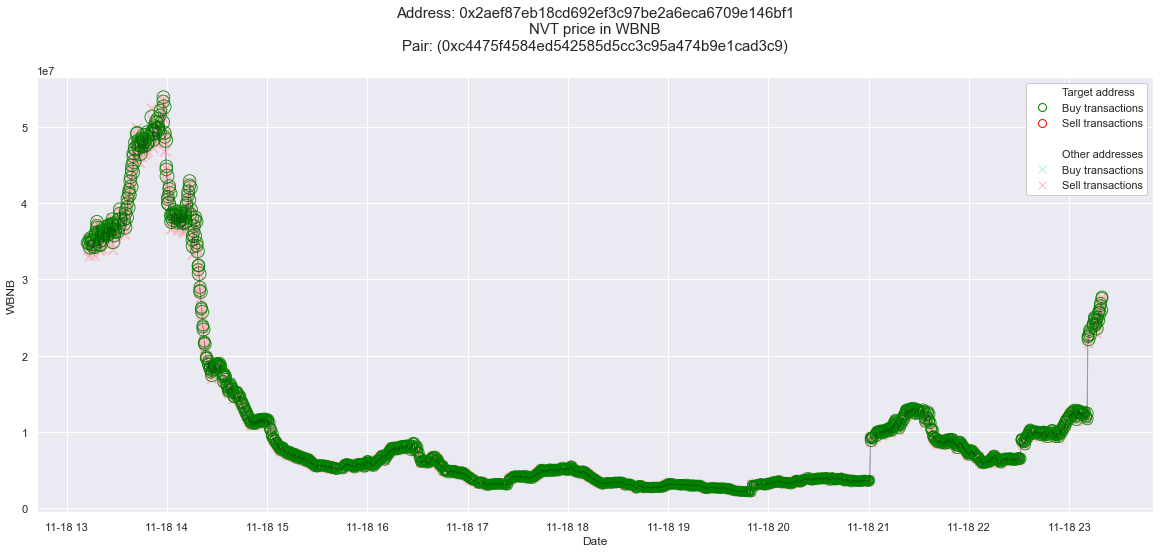

5886


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x2aef87eb18cd692ef3c97be2a6eca6709e146bf1,is_buying
5163,0xc4475f4584ed542585d5cc3c95a474b9e1cad3c9,0x00000000000000000000000000000000000000000000...,23162502,0x67c3ffe9c4d2631e3eaeb0401a788d863355fa13c7e5...,1668777632,5000000000,214661,278,0xd9f92d9ece800fe2b9ffb63d59291ccbd7effdf6fcb2...,138,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x6946ef2fe060b377f306a32c916b1f0e0c63b0e6,2022-11-18 13:20:32,26187260124079898,0,0,900000000000000000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.436786e+07,2.909696e-08,79.574271,False,False
16383,0xc4475f4584ed542585d5cc3c95a474b9e1cad3c9,0x00000000000000000000000000000000000000000000...,23162916,0x2d2844b4b9b3ad1c941dc09a0f56fd44fbc79f4815aa...,1668778874,5000000000,280049,240,0x7a05a4cdd0c18b04ec3119cce09f072b72875c706657...,66,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x2aef87eb18cd692ef3c97be2a6eca6709e146bf1,2022-11-18 13:41:14,0,528701933159100439290519553,11230875000000000000,0,3.5367,1930.0,14.0,1.181799e+29,0.023834,True,0xc4475f4584ed542585d5cc3c95a474b9e1cad3c9,8.277663e+21,3.173736e+29,0,118179915701488549065569919278,118179915701488549065569919278,11360003174999999989600,0,11360003174999999989600,0.017624,3.276410e-10,True,4.707576e+07,2.124236e-08,88.772585,True,True
21077,0xc4475f4584ed542585d5cc3c95a474b9e1cad3c9,0x00000000000000000000000000000000000000000000...,23163113,0xcb7b13ab5485528766dc9140bc4a05578bcb2d2c1957...,1668779465,5000000000,252977,638,0x321addc9c78b26d31c08e93aa874d69d3e62e997c8f4...,231,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x2aef87eb18cd692ef3c97be2a6eca6709e146bf1,2022-11-18 13:51:05,0,566345399858864600520206564,11048700000000000000,0,3.5367,1930.0,14.0,1.181799e+29,0.023834,True,0xc4475f4584ed542585d5cc3c95a474b9e1cad3c9,8.277663e+21,3.173736e+29,0,118179915701488549065569919278,118179915701488549065569919278,11360003174999999989600,0,11360003174999999989600,0.017624,3.276410e-10,True,5.125901e+07,1.950877e-08,88.871813,True,True
22244,0xc4475f4584ed542585d5cc3c95a474b9e1cad3c9,0x00000000000000000000000000000000000000000000...,23163167,0x02a98b3d74cbc93cc7410e1a2b4bd09cb3b874b3ed20...,1668779627,5000000000,265061,288,0xb578bb14062144a58ab4136e3e521a6a16e5c18e7520...,133,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x2aef87eb18cd692ef3c97be2a6eca6709e146bf1,2022-11-18 13:53:47,0,581887221032782704674517745,11699175000000000000,0,3.5367,1930.0,14.0,1.181799e+29,0.023834,True,0xc4475f4584ed542585d5cc3c95a474b9e1cad3c9,8.277663e+21,3.173736e+29,0,118179915701488549065569919278,118179915701488549065569919278,11360003174999999989600,0,11360003174999999989600,0.017624,3.276410e-10,True,4.973746e+07,2.010557e-08,88.910870,True,True
22644,0xc4475f4584ed542585d5cc3c95a474b9e1cad3c9,0x00000000000000000000000000000000000000000000...,23163184,0x54d6a1fa94b0bd6fb32fdfa4a4356e0e805e7bf7138f...,1668779678,5000000000,265049,647,0xac83c72008047117c650120fcb28241a13b76e84e79a...,222,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x2aef87eb18cd692ef3c97be2a6eca6709e146bf1,2022-11-18 13:54:38,0,545027596507397710888141171,10992750000000001000,0,3.5367,1930.0,14.0,1.181799e+29,0.023834,True,0xc4475f4584ed542585d5cc3c95a474b9e1cad3c9,8.277663e+21,3.173736e+29,0,118179915701488549065569919278,118179915701488549065569919278,11360003174999999989600,

5858
84.88557084206003
1.3903900105976477
83.88475620588144
1.4699118006981455


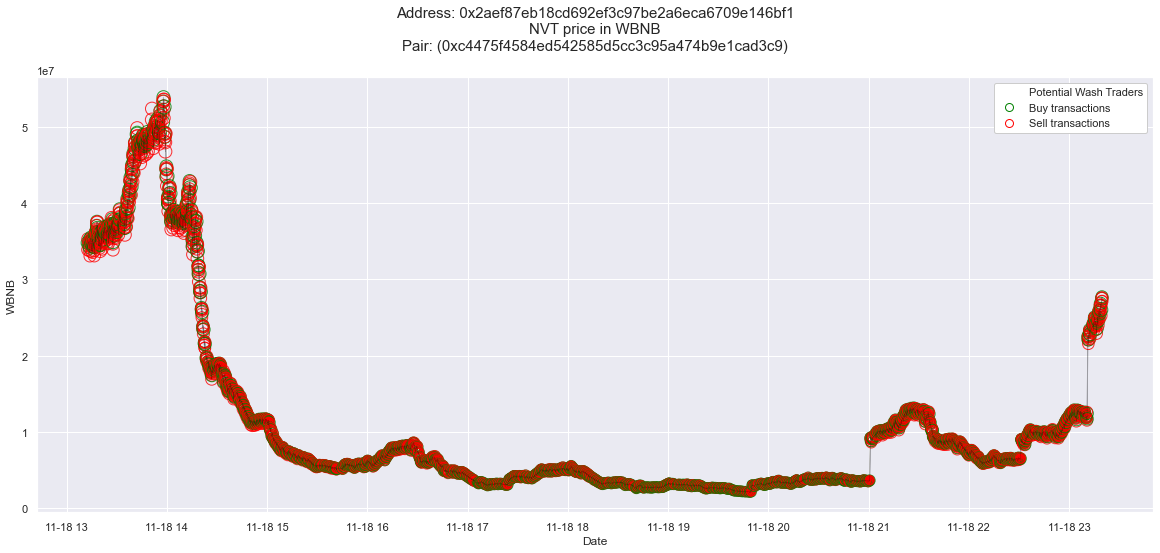

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x2aef87eb18cd692ef3c97be2a6eca6709e146bf1,is_buying
68,0xc4475f4584ed542585d5cc3c95a474b9e1cad3c9,0x00000000000000000000000000000000000000000000...,23162343,0xd164f8b48ffd5e67fd250a3ae0486f2649fcf11766fa...,1668777155,5000000000,163418,485,0x19ddc675ff6c45a61f9c52e0e79e47f46226e82685fc...,141,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xee71db05b8816e2c5e44df0aef61b018467f3b1e,2022-11-18 13:12:35,2199100000000000000,0,0,74499989713565427389671914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.387749e+07,2.951812e-08,85.945443,False,False
135,0xc4475f4584ed542585d5cc3c95a474b9e1cad3c9,0x00000000000000000000000000000000000000000000...,23162346,0x2ce461a3433695a97201473cd0923a1a1be5a0bde6eb...,1668777164,5000000000,265061,296,0x4c7927ddfe4f6f350599fe4306514c6547627b8cf8d3...,86,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x2aef87eb18cd692ef3c97be2a6eca6709e146bf1,2022-11-18 13:12:44,0,294350372392898069880398121,8461050000000000000,0,3.5367,1930.0,14.0,1.181799e+29,0.023834,True,0xc4475f4584ed542585d5cc3c95a474b9e1cad3c9,8.277663e+21,3.173736e+29,0,118179915701488549065569919278,118179915701488549065569919278,11360003174999999989600,0,11360003174999999989600,0.017624,3.276410e-10,True,3.478887e+07,2.874483e-08,87.927665,True,True
136,0xc4475f4584ed542585d5cc3c95a474b9e1cad3c9,0x00000000000000000000000000000000000000000000...,23162346,0x2ce461a3433695a97201473cd0923a1a1be5a0bde6eb...,1668777164,5000000000,265061,300,0x4c7927ddfe4f6f350599fe4306514c6547627b8cf8d3...,86,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x6dfd182b85eaeebdaf38594d06bf1712b61b111d,2022-11-18 13:12:44,2739400000000000000,0,0,96702705479356491467376321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.530069e+07,2.832806e-08,86.321759,False,False
416,0xc4475f4584ed542585d5cc3c95a474b9e1cad3c9,0x00000000000000000000000000000000000000000000...,23162355,0x244e518af969a2427ae0adf58b2c812fc196cb3286e8...,1668777191,5000000000,343266,347,0x5eee35fe91c9432fbf8015ba27cd1ff0717f5797ca20...,132,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x2d37405b2194159ffedb20f60d8c3cab24b76d99,2022-11-18 13:13:11,2362400000000000000,0,0,81160181089216786872015032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.435497e+07,2.910787e-08,86.068974,False,False
417,0xc4475f4584ed542585d5cc3c95a474b9e1cad3c9,0x00000000000000000000000000000000000000000000...,23162355,0x244e518af969a2427ae0adf58b2c812fc196cb3286e8...,1668777191,5000000000,343266,351,0x5eee35fe91c9432fbf8015ba27cd1ff0717f5797ca20...,132,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x2aef87eb18cd692ef3c97be2a6eca6709e146bf1,2022-11-18 13:13:11,0,147260919281823239187696539,4237500000000000000,0,3.5367,1930.0,14.0,1.181799e+29,0.023834,True,0xc4475f4584ed542585d5cc3c95a474b9e1cad3c9,8.277663e+21,3.173736e+29,0,118179915701488549065569919278,118179915701488549065569919278,11360003174999999989600,0,11360003174999999989600,0.017624,3.276410e-10,True,3.475184e+07,2.877546e-08,86.928505,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247526,0xc4475f4584ed542585d5cc3c95a474b9e1cad3c9,0x00000000000000000000000000000000000000000000...,231743

Swapper contract: 0x3b7676bd219d19358ccfaf8ce9f9675bde2ae4f7


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
1,4.327547e+20,True,True,True,0.01,69.275923,NaN,NaN,NaN,4.320525e+20,NaN,NaN,NaN,0.718889,NaN,NaN,NaN


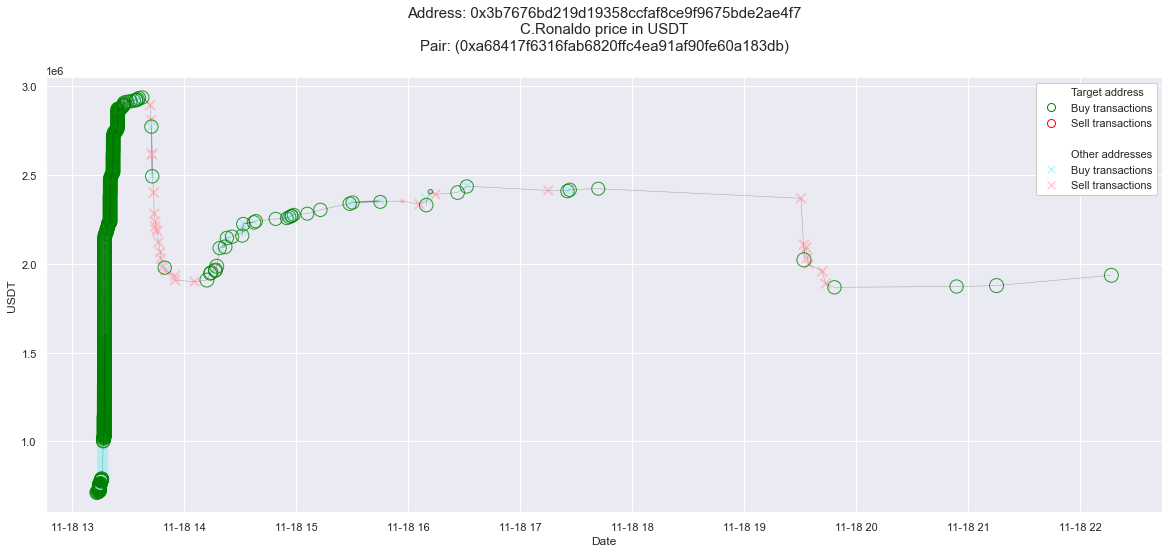

1236


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x3b7676bd219d19358ccfaf8ce9f9675bde2ae4f7,is_buying
16986,0xa68417f6316fab6820ffc4ea91af90fe60a183db,0x00000000000000000000000000000000000000000000...,23162943,0xeb07349dfe80f53d5c9e4ccc9f25637e94922c002a73...,1668778955,6000000000,133047,31,0xd7eef7f1cd2fc472c6ad0df8778c3faa9a622ea2c4f4...,12,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xe79ca6acf34a784e2fe4c04461622ba8468ba9a9,2022-11-18 13:42:35,150000000000000000000,0,0,392709565315503101,0.0147,8.0,0.0,4.803049e+20,0.200000,False,0xa68417f6316fab6820ffc4ea91af90fe60a183db,-1.614329e+18,-4.226416e+15,1261112601754695144,400000000000000000,1661112601754695144,32066520046323750238366,481676645716396544727,32548196692040146783093,2.477253e-13,9.387432e-10,True,2.618064e+06,3.819617e-07,67.027297,False,False
17003,0xa68417f6316fab6820ffc4ea91af90fe60a183db,0x00000000000000000000000000000000000000000000...,23162943,0xeb07349dfe80f53d5c9e4ccc9f25637e94922c002a73...,1668778955,6000000000,133047,31,0xd7eef7f1cd2fc472c6ad0df8778c3faa9a622ea2c4f4...,12,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xe79ca6acf34a784e2fe4c04461622ba8468ba9a9,2022-11-18 13:42:35,150000000000000000000,0,0,392709565315503101,0.0147,8.0,0.0,4.803049e+20,0.200000,False,0xa68417f6316fab6820ffc4ea91af90fe60a183db,-1.614329e+18,-4.226416e+15,1261112601754695144,400000000000000000,1661112601754695144,32066520046323750238366,481676645716396544727,32548196692040146783093,2.477253e-13,9.387432e-10,True,2.618064e+06,3.819617e-07,67.027297,False,False
87560,0xa68417f6316fab6820ffc4ea91af90fe60a183db,0x00000000000000000000000000000000000000000000...,23165590,0xad6bba9785ff037db4ce6078953ff9a6a30dfe5c7f18...,1668787006,5000000000,306305,271,0x57ea8fc61aa19814bb141c92357fc3cd557b292aebad...,100,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x8ef7fb2c6c5638278c078f7fc4cbc9cb66addb3a,2022-11-18 15:56:46,1562500250,0,0,3676945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.353244e+06,4.249452e-07,30.544600,False,False
94927,0xa68417f6316fab6820ffc4ea91af90fe60a183db,0x00000000000000000000000000000000000000000000...,23165872,0xdeb2bb0793456e740e47545dfa4c5cd78e1cb1413a41...,1668787906,5000000000,600608,447,0x093a6e7600dc4273666eed76da7d1a3f600fdd31ce93...,142,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x3b7676bd219d19358ccfaf8ce9f9675bde2ae4f7,2022-11-18 16:11:46,0,252196,104799541,0,1.1013,601.0,457.0,4.327547e+20,0.008319,True,0xa68417f6316fab6820ffc4ea91af90fe60a183db,-5.107844e+20,-3.804142e+17,0,702191707626061228,702191707626061228,432052524590006762085,0,432052524590006762085,1.047194e-13,1.246110e-11,True,2.406461e+06,4.155480e-07,26.646525,True,True
184931,0xa68417f6316fab6820ffc4ea91af90fe60a183db,0x00000000000000000000000000000000000000000000...,23169838,0xd2b9ce72b35ce529718a76ccd00aa5458affbbabc222...,1668799916,5000000000,227908,48,0x2f6e881a6b0395fd2c1afd4334bc319014e06cda25db...,29,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xf0a565fc2f9a78cfdacf167091f11aca91109912,2022-11-18 19:31:56,150000000000000000000,0,0,316305981723163940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.108707e+06,4.742244e-07,67.026563,False,False


1231
59.025038953874024
1.5767872557305194
61.5389887515112
1.6825510024870873


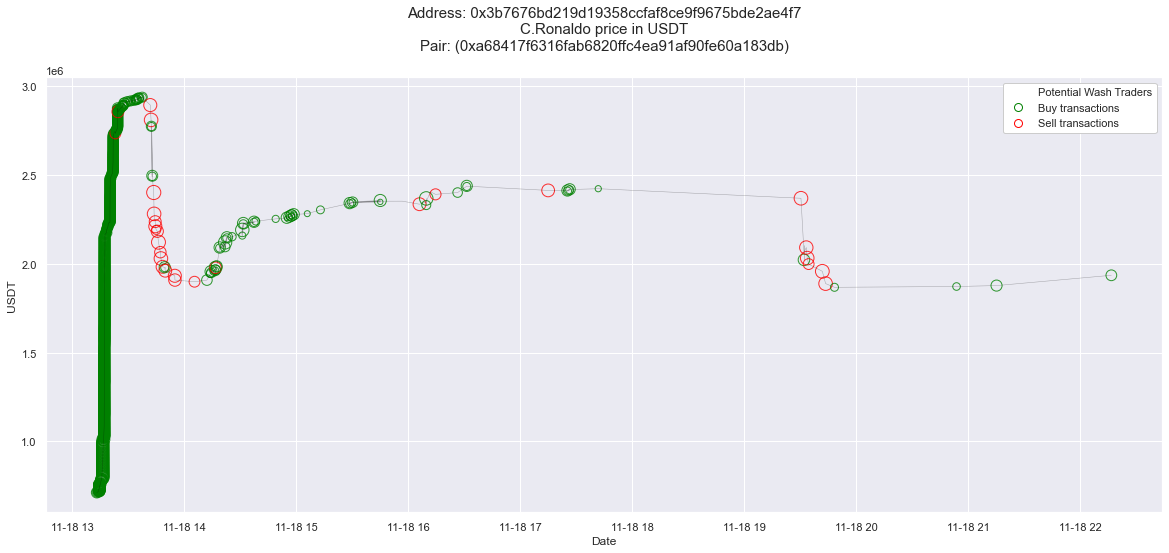

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x3b7676bd219d19358ccfaf8ce9f9675bde2ae4f7,is_buying
317,0xa68417f6316fab6820ffc4ea91af90fe60a183db,0x00000000000000000000000000000000000000000000...,23162352,0xebc2bcac7b85b3f1d1be8ea62b992ae6027fd05a5abd...,1668777182,5000000000,540597,315,0x9a7b41f46eab7c42c5fd3acd1f06164949608df1506a...,68,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x3b7676bd219d19358ccfaf8ce9f9675bde2ae4f7,2022-11-18 13:13:02,0,1967999999999636,2766030088807203002,0,1.1013,601.0,457.0,4.327547e+20,0.008319,True,0xa68417f6316fab6820ffc4ea91af90fe60a183db,-5.107844e+20,-3.804142e+17,0,702191707626061228,702191707626061228,432052524590006762085,0,432052524590006762085,1.047194e-13,1.246110e-11,True,7.114890e+05,1.405503e-06,61.263549,True,True
498,0xa68417f6316fab6820ffc4ea91af90fe60a183db,0x00000000000000000000000000000000000000000000...,23162358,0x5798c7c2f91fc2201b89fd276145d300234177a7d39c...,1668777200,5000000000,604933,324,0xab8a5e00e4e94bf8f101cc50d6305a7fdb02286de0c2...,92,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x3b7676bd219d19358ccfaf8ce9f9675bde2ae4f7,2022-11-18 13:13:20,0,1308798976316594,1834162730680924037,0,1.1013,601.0,457.0,4.327547e+20,0.008319,True,0xa68417f6316fab6820ffc4ea91af90fe60a183db,-5.107844e+20,-3.804142e+17,0,702191707626061228,702191707626061228,432052524590006762085,0,432052524590006762085,1.047194e-13,1.246110e-11,True,7.135675e+05,1.401409e-06,60.670856,True,True
709,0xa68417f6316fab6820ffc4ea91af90fe60a183db,0x00000000000000000000000000000000000000000000...,23162365,0xb9c4048a5dc46d689cddf9440dc33f059d9eb35d2fb0...,1668777221,5000000000,540602,448,0x3b45079115101dfce5739219e0938135b5cb82a04ff1...,219,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x3b7676bd219d19358ccfaf8ce9f9675bde2ae4f7,2022-11-18 13:13:41,0,927448113403299,1296198485771778462,0,1.1013,601.0,457.0,4.327547e+20,0.008319,True,0xa68417f6316fab6820ffc4ea91af90fe60a183db,-5.107844e+20,-3.804142e+17,0,702191707626061228,702191707626061228,432052524590006762085,0,432052524590006762085,1.047194e-13,1.246110e-11,True,7.155140e+05,1.397597e-06,60.170024,True,True
780,0xa68417f6316fab6820ffc4ea91af90fe60a183db,0x00000000000000000000000000000000000000000000...,23162368,0x893c51e2615875d9731cd44df9250c62491e249f6df9...,1668777230,5000000000,589945,332,0x3737612d4d5562436f4f6e3ce0463cab7657a3a08df0...,175,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x3b7676bd219d19358ccfaf8ce9f9675bde2ae4f7,2022-11-18 13:13:50,0,890335532262901,1241192210065357387,0,1.1013,601.0,457.0,4.327547e+20,0.008319,True,0xa68417f6316fab6820ffc4ea91af90fe60a183db,-5.107844e+20,-3.804142e+17,0,702191707626061228,702191707626061228,432052524590006762085,0,432052524590006762085,1.047194e-13,1.246110e-11,True,7.173228e+05,1.394072e-06,60.107467,True,True
1095,0xa68417f6316fab6820ffc4ea91af90fe60a183db,0x00000000000000000000000000000000000000000000...,23162379,0xb44aeae55c6ae17a50dc8ed6dd4aa7d7f9a2e4cda289...,1668777263,6000000000,515503,74,0x1ef6adba2bc92b53e28af31bf4d632e76b96c8dd3b39...,26,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x3b7676bd219d19358ccfaf8ce9f9675bde2ae4f7,2022-11-18 13:14:23,0,732587484230253,1019128808460336804,0,1.1013,601.0,457.0,4.327547e+20,0.008319,True,0xa68417f6316fab6820ffc4ea91af90fe60a183db,-5.107844e+20,-3.804142e+17,0,702191707626061228,702191707626061228,432052524590006762085,

Swapper address: 0x581478e4b12b7cf981dad77eda039a56cbfcc512


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
2,1.3,True,False,True,0.37,-1140.653142,NaN,NaN,NaN,6.342685e+22,NaN,NaN,NaN,131.318534,NaN,NaN,NaN


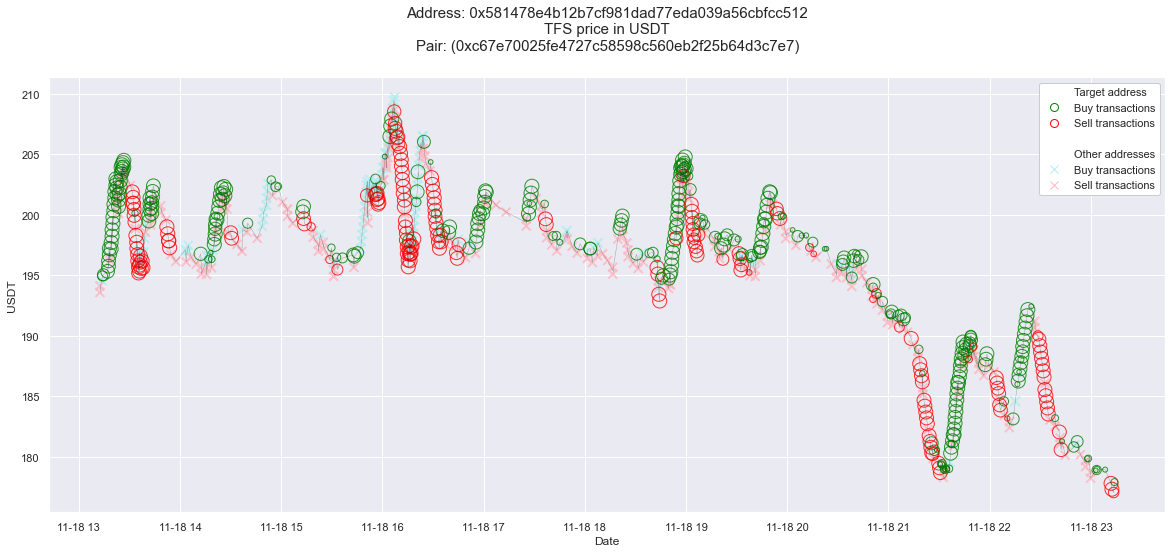

851


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x581478e4b12b7cf981dad77eda039a56cbfcc512,is_buying
28347,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,0x00000000000000000000000000000000000000000000...,23163370,0xeae8620f8b4c4ec6926c867b5c65cf525fe769e6c3de...,1668780236,5000000000,119506,74,0x8ca0ed573609f84c66db82d12895740b098095ed340d...,23,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x47e09b561a19c679a27aa3f162b27accb44201c9,2022-11-18 14:03:56,0,195000000000000000000,990807539023825562,0,0.0165,9.0,0.0,2.926078e+23,0.444444,True,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,3.173767e+18,6.255790e+20,0,291127615549688415305505,291127615549688415305505,1480159483086925815882,0,1480159483086925815882,4.341649e-08,4.269022e-11,True,196.809161,0.005081,67.409348,False,True
146396,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,0x00000000000000000000000000000000000000000000...,23167795,0x461e17fca22398db181dfa31f3e31da6a85d7fbfc238...,1668793768,5005000000,128218,133,0x180ae6f5934b1992d79bbf81f65e5b5b92b493739ab1...,66,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xea65a0c33924190b1f08f199ab8b2a27b2ad3199,2022-11-18 17:49:28,1000000000000000000,0,0,198248924815545433500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,198.248925,0.005044,67.433134,False,False
146446,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,0x00000000000000000000000000000000000000000000...,23167797,0xbc46088ac981bff65827991fe13557a207d3a052a32c...,1668793774,5000000000,110387,169,0xb6736d7ca5cee8aeb9caa3f39bb62c7349b7cd76c4b3...,54,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xea65a0c33924190b1f08f199ab8b2a27b2ad3199,2022-11-18 17:49:34,0,198248924815545433500,997878194106796318,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,198.670465,0.005033,67.433118,False,True
152086,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,0x00000000000000000000000000000000000000000000...,23168035,0xb44af2d34b6bac9f85eb618c87ac4a19dc623c237811...,1668794489,5005000000,128218,431,0xc5a38c5158242fcc047b5b0bfd78dbbb478bdbd2c95f...,123,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xea65a0c33924190b1f08f199ab8b2a27b2ad3199,2022-11-18 18:01:29,1000000000000000000,0,0,196671442927502600596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,196.671443,0.005085,67.421666,False,False
152183,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,0x00000000000000000000000000000000000000000000...,23168037,0x7443f581b6abea5db18b358b8370fd33ee362bb4eaa8...,1668794495,5000000000,98303,340,0x703c11b2d64f49cae5c1294380daca9e0943cc7c6179...,101,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xea65a0c33924190b1f08f199ab8b2a27b2ad3199,2022-11-18 18:01:35,0,196671442927502600596,997852330522089816,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,197.094737,0.005074,67.421651,False,True
202202,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,0x00000000000000000000000000000000000000000000...,23171025,0x78e6b3d323d8f7b55adbd8e704e0439a2b854d001742...,1668803528,5005000000,140302,50,0x942404b8b0cbfa5aeb1d04883fd7e0b3875f12182872...,23,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xea65a0c33924190b1f08f199ab8b2a27b2ad3199,2022-11-18 20:32:08,1000000000000000000,0,0,195404699408925974921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,195.404699,0.005118,67.412391,False,False


833
73.73365165072825
1.9962506092613543
74.75203553930855
1.7929317599788859


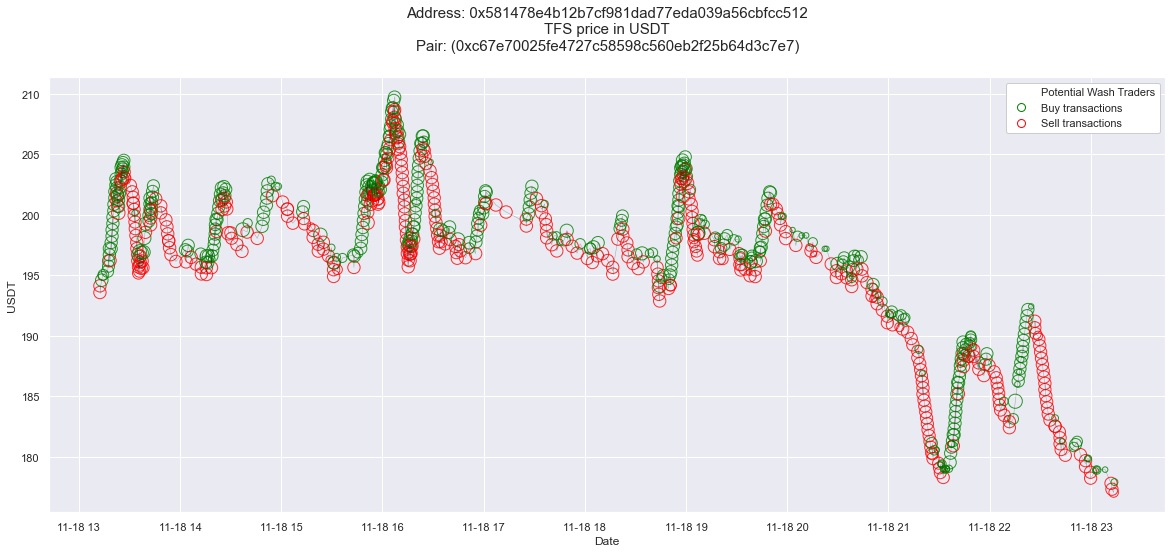

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x581478e4b12b7cf981dad77eda039a56cbfcc512,is_buying
19,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,0x00000000000000000000000000000000000000000000...,23162342,0x9edc02e6a423e7fc6870345a68cb5f3b3ea5538f77d7...,1668777152,5000000000,119562,247,0x83b3f750b9772c34b82b71c0e3ff84bf8e3f360a3c78...,127,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x5066c17070a7a5dea6bdf4c8eaa87acb971abb49,2022-11-18 13:12:32,199000000000000000000,0,0,38631783398688358910601,0.3262,178.0,33.0,6.929106e+24,0.994382,True,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,1.902374e+20,3.682545e+22,6893683842073876234397688,0,6893683842073876234397688,0,35422000000000000000000,35422000000000000000000,1.028070e-06,1.021628e-09,True,194.129565,0.005151,75.039619,False,False
21,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,0x00000000000000000000000000000000000000000000...,23162342,0x9edc02e6a423e7fc6870345a68cb5f3b3ea5538f77d7...,1668777152,5000000000,107478,299,0xd160525c51e4d1f9d886458a120a5823a557af17bcce...,143,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x5066c17070a7a5dea6bdf4c8eaa87acb971abb49,2022-11-18 13:12:32,199000000000000000000,0,0,38521676369082250176342,0.3262,178.0,33.0,6.929106e+24,0.994382,True,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,1.902374e+20,3.682545e+22,6893683842073876234397688,0,6893683842073876234397688,0,35422000000000000000000,35422000000000000000000,1.028070e-06,1.021628e-09,True,193.576263,0.005166,75.035522,False,False
657,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,0x00000000000000000000000000000000000000000000...,23162364,0x316d8d3260ac4ea0bef4a8ee071eb22ca8af85bcfb89...,1668777218,6000000000,104554,107,0xf30eeefe4e151364a03261b5d5fe843eaacc2e8f726e...,41,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x41d3bf7d2c519e9121e2cffde7c757a463930ab2,2022-11-18 13:13:38,0,45308400740509891900728,232834278072729342496,0,0.0586,32.0,0.0,1.162288e+00,0.531250,True,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,1.182714e+20,2.301504e+22,771093682141258542053786,896088936716293378822559,1667182618857551920876345,4560606608335196793259,3800000000000000000000,8360606608335196793259,2.486305e-07,2.411335e-10,True,194.595062,0.005139,75.269592,False,True
908,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,0x00000000000000000000000000000000000000000000...,23162373,0x0c339c83cf099e4d7132895dbe28094b4fc9b8ed545e...,1668777245,5000000000,119530,142,0x5d0bf7d7841985b76d7e955d535e0200b387425b0b66...,70,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x581478e4b12b7cf981dad77eda039a56cbfcc512,2022-11-18 13:14:05,0,3455480000000000000000,17725309081473188512,0,0.8851,483.0,82.0,1.302240e+00,0.374741,True,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,-4.750765e+20,-9.112330e+22,5405037575869952156099368,7038981239100000000000000,12444018814969952156099368,35735216397430934206632,27691635500000000000000,63426851897430934206632,1.855803e-06,1.829334e-09,True,194.946107,0.005130,71.556758,True,True
1259,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,0x00000000000000000000000000000000000000000000...,23162383,0xd8b26fa1db5fce8bc3035996455971ef38f1cbc1ae73...,1668777275,5000000000,119554,191,0x68b9f437fdbd73a4ae7a939d89890ab9e9595c80bb78...,110,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x581478e4b12b7cf981dad77eda039a56cbfcc512,2022-11-18 13:14:35,0,10087140000000000000000,51717400258397783709,0,0.885

Swapper contract: 0x5e26adac0eeb658381cff8e2f1188e648383dce0


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
3,7.454087e+21,True,True,True,0.01,2470.927387,NaN,NaN,NaN,7.454086e+21,NaN,NaN,NaN,17.705667,NaN,NaN,NaN


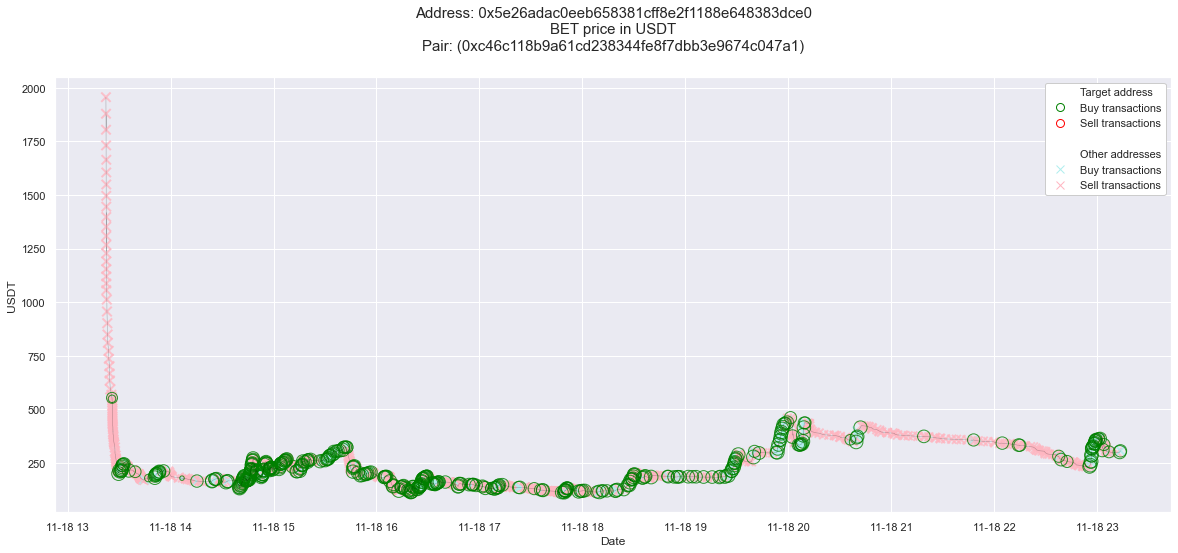

2273


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x5e26adac0eeb658381cff8e2f1188e648383dce0,is_buying
8070,0xc46c118b9a61cd238344fe8f7dbb3e9674c047a1,0x00000000000000000000000000000000000000000000...,23162608,0x8cf433062ecb54126015c016bac9960727a60668dc12...,1668777950,15000000000,880223,34,0x8cee594dc93dc98fe8242a0d7c323f40322cd0ad1f24...,6,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x5e26adac0eeb658381cff8e2f1188e648383dce0,2022-11-18 13:25:50,0,65462480571,118228065164412458,0,0.7715,421.0,15.0,7.454087e+21,0.014252,True,0xc46c118b9a61cd238344fe8f7dbb3e9674c047a1,-2.629745e+21,-3.985044e+14,0,1528076592431218,1528076592431218,7454085669343285921509,0,7454085669343285921509,2.278853e-16,2.149880e-10,True,553.696624,0.001806,56.714351,True,True
8107,0xc46c118b9a61cd238344fe8f7dbb3e9674c047a1,0x00000000000000000000000000000000000000000000...,23162608,0x8cf433062ecb54126015c016bac9960727a60668dc12...,1668777950,5000000000,932731,559,0x5aa175b95540cc1b1ec0e01c91bb81811d9d02deba80...,192,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x5e26adac0eeb658381cff8e2f1188e648383dce0,2022-11-18 13:25:50,0,181342224,330077733063350,0,0.7715,421.0,15.0,7.454087e+21,0.014252,True,0xc46c118b9a61cd238344fe8f7dbb3e9674c047a1,-2.629745e+21,-3.985044e+14,0,1528076592431218,1528076592431218,7454085669343285921509,0,7454085669343285921509,2.278853e-16,2.149880e-10,True,549.392479,0.001820,48.229800,True,True
18804,0xc46c118b9a61cd238344fe8f7dbb3e9674c047a1,0x00000000000000000000000000000000000000000000...,23163018,0x7306edede0271302606712d35d3d2c957b2d42523379...,1668779180,5000000000,298348,256,0x53f0ac9e995fcb65c29b64375ae696175243fbb65fc3...,67,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xdbc1457a83559d072653da076a7519ad7a998fd3,2022-11-18 13:46:20,2726783195687012,0,0,488081987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,178.995524,0.005587,51.276122,False,False
19127,0xc46c118b9a61cd238344fe8f7dbb3e9674c047a1,0x00000000000000000000000000000000000000000000...,23163031,0xbe23371a1a4d9002ed57aea8f176640de4cd78e41dd5...,1668779219,5000000000,588387,264,0x38218b31531fb672f3599f6a31664af6a62130ed5eda...,107,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x5e26adac0eeb658381cff8e2f1188e648383dce0,2022-11-18 13:46:59,0,59179867,329058241743814,0,0.7715,421.0,15.0,7.454087e+21,0.014252,True,0xc46c118b9a61cd238344fe8f7dbb3e9674c047a1,-2.629745e+21,-3.985044e+14,0,1528076592431218,1528076592431218,7454085669343285921509,0,7454085669343285921509,2.278853e-16,2.149880e-10,True,179.846178,0.005560,48.225337,True,True
29924,0xc46c118b9a61cd238344fe8f7dbb3e9674c047a1,0x00000000000000000000000000000000000000000000...,23163424,0x2d3f52ab311fdcec5f07c8abf7fc0ba874d0fe581710...,1668780398,5000000000,825410,327,0x44decfc08b021d27f490083a6e1ed89e660d020665ab...,100,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x5e26adac0eeb658381cff8e2f1188e648383dce0,2022-11-18 14:06:38,0,2162210,12064959071694,0,0.7715,421.0,15.0,7.454087e+21,0.014252,True,0xc46c118b9a61cd238344fe8f7dbb3e9674c047a1,-2.629745e+21,-3.985044e+14,0,1528076592431218,1528076592431218,7454085669343285921509,0,7454085669343285921509,2.278853e-16,2.149880e-10,True,179.214035,0.005580,43.455889,True,True
29925,0xc46c118b9a61cd238344fe8f7dbb3e9674c047a1,0x00000000000000000000000000000000000000000000...,23163424,0x2d3f52ab311fdcec5f07c8abf7fc0ba

2263
62.77092741921329
2.477315653076338
64.180805969971
2.116999696818625


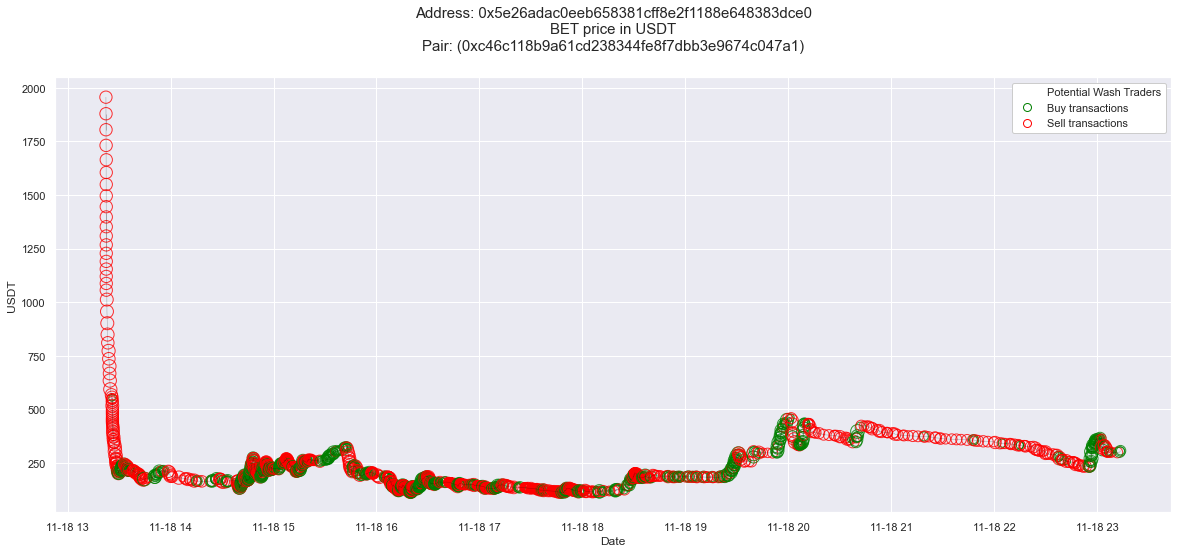

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x5e26adac0eeb658381cff8e2f1188e648383dce0,is_buying
6204,0xc46c118b9a61cd238344fe8f7dbb3e9674c047a1,0x00000000000000000000000000000000000000000000...,23162537,0xd900704e4056c1045c5311d64078afd6158b74d94bd8...,1668777737,5500000000,348610,94,0xe1f7f3461b163c077efb2c13b6510622ea6604cb82f3...,46,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xeac6b54c8a55b07bdf19ad472ed607c6ea81995d,2022-11-18 13:22:17,99700000000000000000,0,0,195022473743863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1956.093016,0.000511,66.434230,False,False
6226,0xc46c118b9a61cd238344fe8f7dbb3e9674c047a1,0x00000000000000000000000000000000000000000000...,23162538,0xdc2622940272e4751f2ec2a7a6ff66705d34289a1c60...,1668777740,7000000000,240070,40,0xb94a8fa267046a87bd2fa4019c4681e7774cc352ac0b...,12,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x5a00025c780f806389ca4f4dc139a2fa2ac00eeb,2022-11-18 13:22:20,105905552492030618463,0,0,198989000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1878.928869,0.000532,66.521343,False,False
6247,0xc46c118b9a61cd238344fe8f7dbb3e9674c047a1,0x00000000000000000000000000000000000000000000...,23162538,0xdc2622940272e4751f2ec2a7a6ff66705d34289a1c60...,1668777740,5000000000,227986,418,0x36670d8d2bcd8ec9905894a22b8fda369b5ffbf03fa7...,121,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xc5ac190d4a0a4590b8c55553af3da14ac62fa700,2022-11-18 13:22:20,105304282391116250761,0,0,190000000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1804.295093,0.000554,66.513129,False,False
6279,0xc46c118b9a61cd238344fe8f7dbb3e9674c047a1,0x00000000000000000000000000000000000000000000...,23162539,0x6d5e1b82521a5a74d331b51e7b9a2ba0b767c48da21d...,1668777743,5000000000,150752,109,0x869ee7eeaf86fb3f5d3f8b7856573f80bc897c240260...,25,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xa546383a903567f9da3050f1ef0756d177f54b6c,2022-11-18 13:22:23,114657885776620003430,0,0,198500000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1731.237225,0.000578,66.635900,False,False
6338,0xc46c118b9a61cd238344fe8f7dbb3e9674c047a1,0x00000000000000000000000000000000000000000000...,23162541,0xaf22b743ee2084e4741c61e8ec39d3fa17027a66ce65...,1668777749,6000000000,231210,62,0x545c4acefe005282999aac73fa736f61995b43f96059...,33,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xef0e6449a8f381a6eabe627dd609f7530f1fde27,2022-11-18 13:22:29,100000000000000000000,0,0,166405721259457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1664.057213,0.000601,66.438564,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244468,0xc46c118b9a61cd238344fe8f7dbb3e9674c047a1,0x00000000000000000000000000000000000000000000...,23174111,0x21e9cc3e30f5e8e92b4c94b316d6d3112cebcfcb5bc8...,1668812897,5000000000,216270,69,0x4a95264709656f7b9765037946ca7b6c3c92f36abed6...,20,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x0aa9519fa160bca11d47d9b016cb828209d65bec,2022-11-18 23:08:17,13230868695664899603,0,0,3968095743170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,299.911958,0.003334,63.520542,False,False
245507,0xc46c118b9a61cd23834

Swapper contract: 0xba8c06be90fa46d634515716eae4ffc3a8bfc4cd


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
4,1.83,True,True,True,0.27,NaN,-700.330195,NaN,NaN,NaN,8.315223e+22,NaN,NaN,NaN,282.830717,NaN,NaN


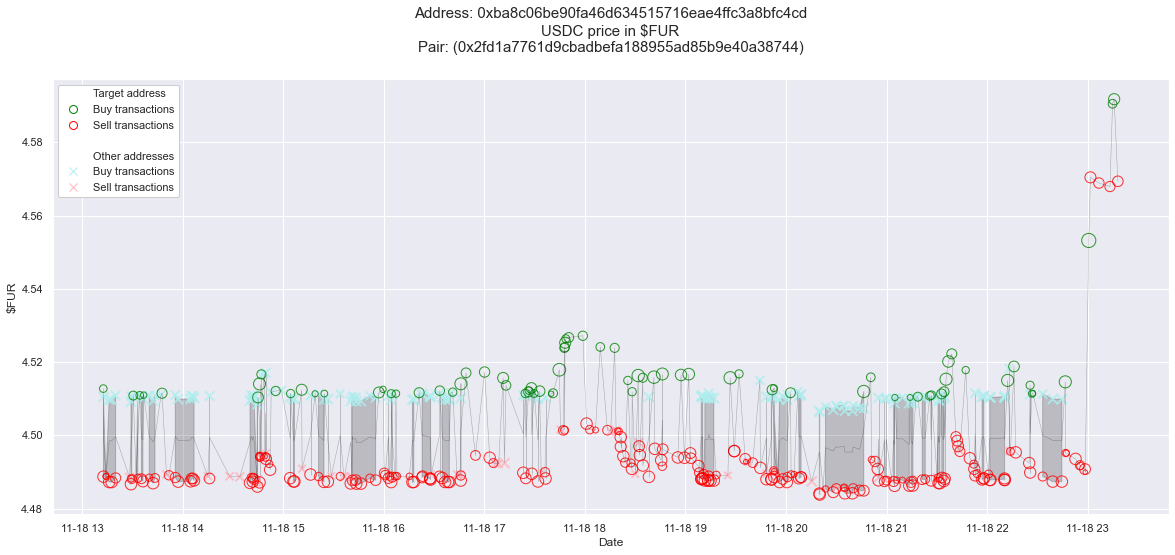

490


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0xba8c06be90fa46d634515716eae4ffc3a8bfc4cd,is_buying
139567,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,0x00000000000000000000000000000000000000000000...,23167484,0x9c1718e2e98ddf44dc3834bb08fbf06670f980d181a5...,1668792835,5000000000,724911,195,0x53639896cb8eca6b94abc025b7ca1c9a13b926564c9a...,83,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x77f50d741997dbbbb112c58dec50315e2de8da58,2022-11-18 17:33:55,47686831545488162,0,0,214120132137551491,0.1209,66.0,0.0,4.136817,0.045455,True,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,-2.604425e+18,-1.176727e+19,1926250399636242076156,466089115184333741001,2392339514820575817157,103258832115934495108,429037760987344430848,532296593103278925956,3.567747e-10,1.535230e-11,False,4.490131,0.222711,57.861281,False,False
159337,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,0x00000000000000000000000000000000000000000000...,23168378,0x81fd9c495b04a1682d3bca0fa91bf4f1dbe770650dfb...,1668795518,5000000000,906654,189,0x183915b83f25607c21d74281b57dd2dede18e4543701...,55,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x77f50d741997dbbbb112c58dec50315e2de8da58,2022-11-18 18:18:38,31384267015719320,0,0,141265878265920156,0.1209,66.0,0.0,4.136817,0.045455,True,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,-2.604425e+18,-1.176727e+19,1926250399636242076156,466089115184333741001,2392339514820575817157,103258832115934495108,429037760987344430848,532296593103278925956,3.567747e-10,1.535230e-11,False,4.501169,0.222165,57.260629,False,False
191881,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,0x00000000000000000000000000000000000000000000...,23170294,0x99fa65f0baf5dff4ab506607de1e013e81908ec14a85...,1668801308,5000000000,888822,146,0x9494e5e8bae6fab2b66f3aacea1b36b217f6e534cf12...,29,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x77f50d741997dbbbb112c58dec50315e2de8da58,2022-11-18 19:55:08,1792320957764198,0,0,8045333128373194,0.1209,66.0,0.0,4.136817,0.045455,True,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,-2.604425e+18,-1.176727e+19,1926250399636242076156,466089115184333741001,2392339514820575817157,103258832115934495108,429037760987344430848,532296593103278925956,3.567747e-10,1.535230e-11,False,4.488779,0.222778,53.127236,False,False
199586,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,0x00000000000000000000000000000000000000000000...,23170825,0x8f1134b0cccf87d2818dbb38758a3eff1f6ae15aabc4...,1668802928,5000000000,359959,73,0x7e41495e82f43d9b09bc23b437ccc9de311b58130ba3...,16,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x77f50d741997dbbbb112c58dec50315e2de8da58,2022-11-18 20:22:08,2668450585475110,0,0,11968988667872226,0.1209,66.0,0.0,4.136817,0.045455,True,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,-2.604425e+18,-1.176727e+19,1926250399636242076156,466089115184333741001,2392339514820575817157,103258832115934495108,429037760987344430848,532296593103278925956,3.567747e-10,1.535230e-11,False,4.485370,0.222947,53.700513,False,False
210756,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,0x00000000000000000000000000000000000000000000...,23171643,0xbdd7da783407285d9571291d93e3cdea8af3b9df5eaf...,1668805382,5000000000,383814,77,0x4ba1c3d79f2aedddb9c7e3e883dcc99c6dca57e8b35a...,19,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x77f50d741997dbbbb112c58dec50315e2de8da58,2022-11-18 21:03:02,5948503956879356,0,0,26695440681717259,0.1209,66.0,0.0,4.136817,0.0

485
66.84736477055252
2.3020954423532944
65.876137153285
3.4161712450525807


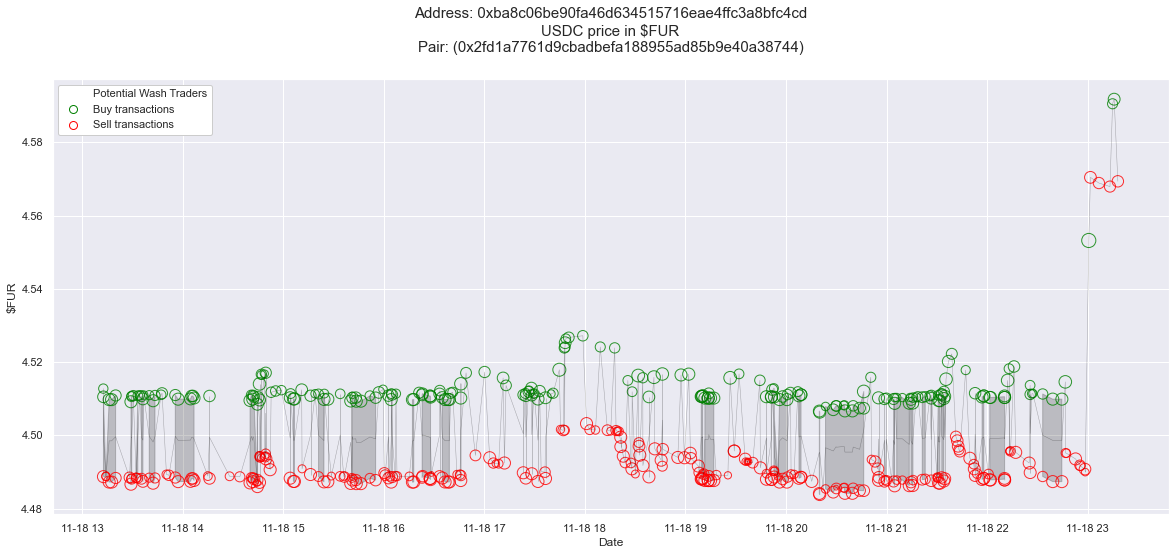

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0xba8c06be90fa46d634515716eae4ffc3a8bfc4cd,is_buying
109,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,0x00000000000000000000000000000000000000000000...,23162345,0x4332031bacb9f39dc352b865dc5cef5281566b28b74a...,1668777161,5000000000,330674,95,0xcc92f8a00c9488189fd43bc51c6c9d908823e799ecee...,53,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xba8c06be90fa46d634515716eae4ffc3a8bfc4cd,2022-11-18 13:12:41,0,13566735000000000000,3006310664452994710,0,0.5388,294.0,4.0,1.830537,0.272109,True,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,-9.250831e+19,-4.179344e+20,53743895240474298367507,29408335514187282457370,83152230754661580824877,6489695795114674261110,11968794471251248951029,18458490266365923212139,1.240067e-08,5.323730e-10,True,4.512752,0.221594,63.845473,True,True
181,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,0x00000000000000000000000000000000000000000000...,23162347,0xc2ddece23b4e51cfe0d027a3100ff941e8589cb58c41...,1668777167,5000000000,629227,273,0x4830fa00a4073c39801151d6734bd8f85aec5f7dfbe0...,102,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xba8c06be90fa46d634515716eae4ffc3a8bfc4cd,2022-11-18 13:12:47,100000000000000000000,0,0,448871566305864775098,0.5388,294.0,4.0,1.830537,0.272109,True,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,-9.250831e+19,-4.179344e+20,53743895240474298367507,29408335514187282457370,83152230754661580824877,6489695795114674261110,11968794471251248951029,18458490266365923212139,1.240067e-08,5.323730e-10,True,4.488716,0.222781,68.895031,True,False
182,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,0x00000000000000000000000000000000000000000000...,23162347,0xc2ddece23b4e51cfe0d027a3100ff941e8589cb58c41...,1668777167,5000000000,629227,279,0x4830fa00a4073c39801151d6734bd8f85aec5f7dfbe0...,102,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x10e5ba76a18cc67778528e8255dd1827f8939cc3,2022-11-18 13:12:47,0,238500000000000000000,52876516177020674370,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,4.510509,0.221704,67.981447,False,True
980,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,0x00000000000000000000000000000000000000000000...,23162376,0x774c34697a6fed7814b9f93eecc4a95fc822bb0b2495...,1668777254,5000000000,345576,188,0x164a325ff39162eb759da3ebce6041b51c321f4046b7...,104,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xba8c06be90fa46d634515716eae4ffc3a8bfc4cd,2022-11-18 13:14:14,989750000000000000,0,0,4442781405960745266,0.5388,294.0,4.0,1.830537,0.272109,True,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,-9.250831e+19,-4.179344e+20,53743895240474298367507,29408335514187282457370,83152230754661580824877,6489695795114674261110,11968794471251248951029,18458490266365923212139,1.240067e-08,5.323730e-10,True,4.488792,0.222777,62.236330,True,False
1010,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,0x00000000000000000000000000000000000000000000...,23162376,0x774c34697a6fed7814b9f93eecc4a95fc822bb0b2495...,1668777254,5000000000,345576,188,0x164a325ff39162eb759da3ebce6041b51c321f4046b7...,104,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xba8c06be90fa46d634515716eae4ffc3a8bfc4cd,2022-11-18 13:14:14,989750000000000000,0,0,4442781405960745266,0.5388,294.0,4.0,1.830537,0.272109,True,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,-9.250831e+19,-4.179344e+20,53743895240474298367507,29408335514187282457370,83152230754661580824877,648969

Swapper contract: 0x6b4813b50c623da72470737b387cb0ff027429b6


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
5,6.088599e+20,True,True,False,0.01,NaN,NaN,NaN,-0.015746,NaN,NaN,NaN,6.654182e+19,NaN,NaN,NaN,0.54099


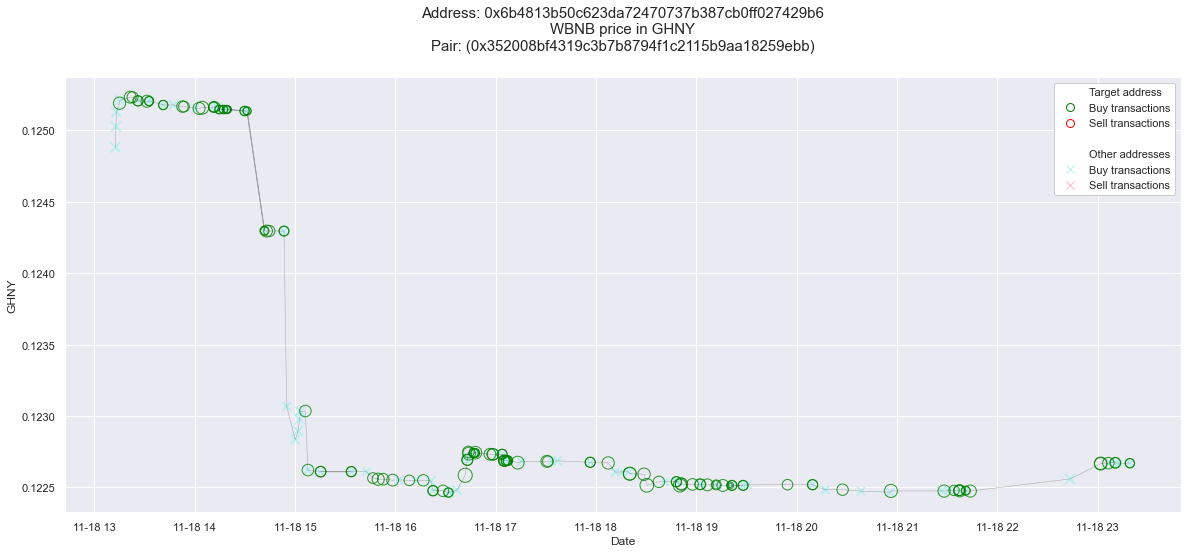

200


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x6b4813b50c623da72470737b387cb0ff027429b6,is_buying


200
56.857787633412855
4.106060677354764
59.62787275585935
4.462853253059617


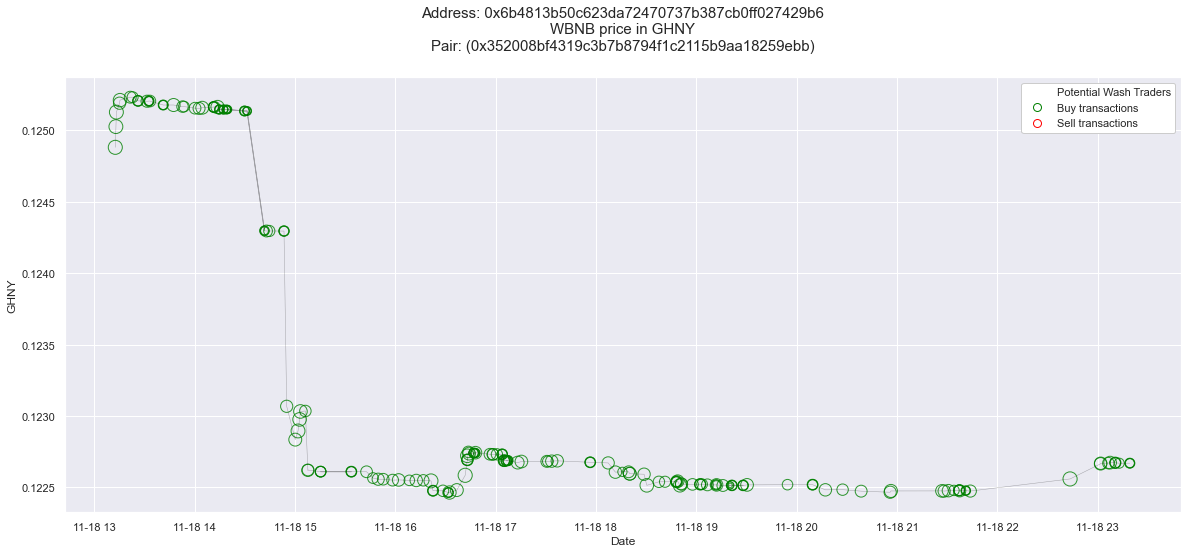

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x6b4813b50c623da72470737b387cb0ff027429b6,is_buying
26,0x352008bf4319c3b7b8794f1c2115b9aa18259ebb,0x00000000000000000000000000000000000000000000...,23162342,0x9edc02e6a423e7fc6870345a68cb5f3b3ea5538f77d7...,1668777152,5000000000,203287,358,0x08e63d342bb48f7e8d9689f228df7ca12020809fb02c...,161,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xf4c369f9ee48a35e7a371a3acbdf6dbce71eaf73,2022-11-18 13:12:32,0,29166235102132874850,233552022954393806256,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.124881,8.007616,67.832078,False,True
233,0x352008bf4319c3b7b8794f1c2115b9aa18259ebb,0x00000000000000000000000000000000000000000000...,23162349,0xbbe2441249da467a58cbde94a8c5792f0a2c398e478a...,1668777173,5000000000,203299,353,0xb24dfa10e261082755e6208cc157f30a80c2c7c18500...,167,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xded228bf40917688325b1910e77351f302336566,2022-11-18 13:12:53,0,18225776899681947358,145775709867778170572,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.125026,7.998326,67.152271,False,True
408,0x352008bf4319c3b7b8794f1c2115b9aa18259ebb,0x00000000000000000000000000000000000000000000...,23162355,0x244e518af969a2427ae0adf58b2c812fc196cb3286e8...,1668777191,5000000000,188323,302,0x86841bf7c138163c24ccdd6bdbd0fc7bb7aff98e5679...,123,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xded228bf40917688325b1910e77351f302336566,2022-11-18 13:13:11,0,21798886739184231423,174213458766822927375,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.125127,7.991851,67.409506,False,True
1490,0x352008bf4319c3b7b8794f1c2115b9aa18259ebb,0x00000000000000000000000000000000000000000000...,23162393,0x2dd9f03b0e44d1770ddd78f04cda2ec67414d8107904...,1668777305,5000000000,723792,197,0xfd95f98ab761aecf04e1ea96a517f5201a0ab1d5533a...,94,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x6b4813b50c623da72470737b387cb0ff027429b6,2022-11-18 13:15:05,0,409464414954454077,3270741428958962470,0,0.4746,259.0,0.0,6.088599e+20,0.00813,False,0x352008bf4319c3b7b8794f1c2115b9aa18259ebb,-9.492004e+17,-1.162623e+17,462245136148577842067,6836108393579151946172,7298353529727729788239,7294776433103264152823,1705650906236844585,7296482084009500997408,1.088419e-09,2.104425e-10,True,0.125190,7.987853,61.674492,True,True
1645,0x352008bf4319c3b7b8794f1c2115b9aa18259ebb,0x00000000000000000000000000000000000000000000...,23162398,0x2a7bc8a47d7e1c83497b885e4c27220b4b3a29a168a3...,1668777320,5000000000,204570,609,0xd789e9e48e4081f0860034d4db7a184785f031edde79...,158,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x21b5ae67e7486f98fdb9224d370f59814085d697,2022-11-18 13:15:20,0,6562454039732484553,52410987348600456551,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.125211,7.986492,65.676699,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245180,0x352008bf4319c3b7b8794f1c2115b9aa18259ebb,0x00000000000000000000000000000000000000000000...,23174158,0xab93a19005c077bdcd4c2aecb2024a48eb2f0757a26e...,1668813038,5000000000,3430169,262,0xa8374fc930c6e178af2e09332135348fb063ff6ea1fa...,62,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x6b4813b50c623da72470737b387cb0ff027

Swapper address: 0x72080625314625d726d09ed340b97386c5e1fb9b


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
6,1.01,True,False,True,0.02,NaN,NaN,-87.679824,NaN,NaN,NaN,3.459761e+22,NaN,NaN,NaN,136.211058,NaN


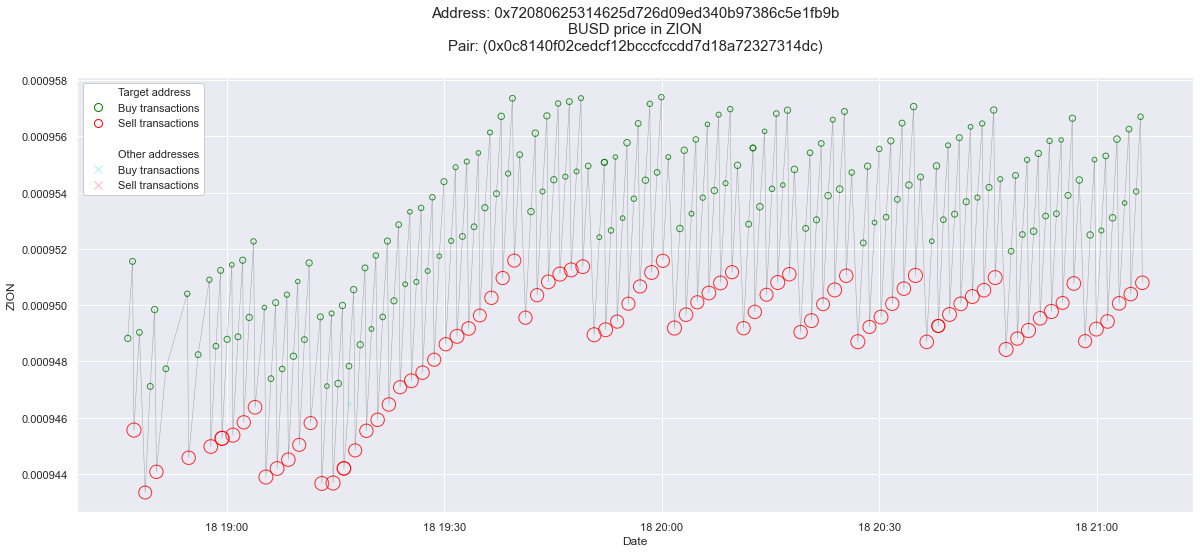

255


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x72080625314625d726d09ed340b97386c5e1fb9b,is_buying
180224,0x0c8140f02cedcf12bcccfccdd7d18a72327314dc,0x00000000000000000000000000000000000000000000...,23169535,0x9aaab7ee0c54820e6cb73c8870f8fd2e7ae2dc293bf3...,1668799007,5000000000,137873,199,0xd548125d85e8e72b277a7123e05a4372fc2ad9e5f4be...,56,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x3a9b45ad2fdd94e8695cd8e35c01972d20cf9d45,2022-11-18 19:16:47,0,10000000000000000,10565251298,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.000946,1056.52513,53.150851,False,True


254
66.82038716247641
0.42094728745248744
53.15085104244056
nan


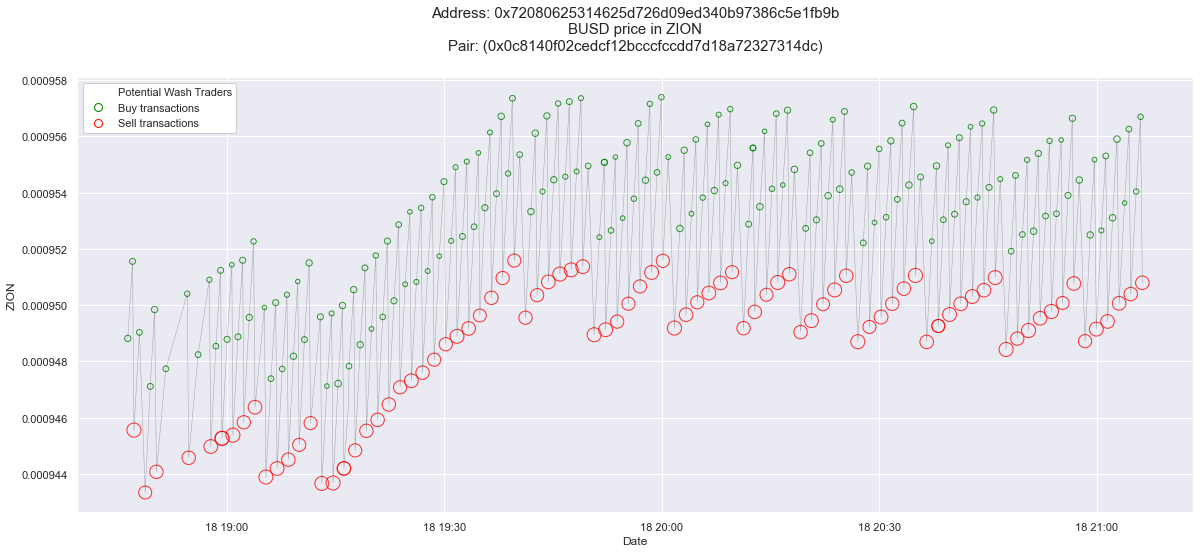

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x72080625314625d726d09ed340b97386c5e1fb9b,is_buying
169469,0x0c8140f02cedcf12bcccfccdd7d18a72327314dc,0x00000000000000000000000000000000000000000000...,23168926,0x3bb56518f75aa8f24cbf006fac55238284f7fdc74545...,1668797179,5000000000,129279,267,0x8484d85767209bb4b830c30b183bdb4bf2d5295f4fb2...,96,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x72080625314625d726d09ed340b97386c5e1fb9b,2022-11-18 18:46:19,0,108425832678199360000,114274522185095,0,0.4655,254.0,0.0,1.005673,0.019685,True,0x0c8140f02cedcf12bcccfccdd7d18a72327314dc,-9.292301e+13,-8.896106e+19,17347737248899438111513,17249871499477194870000,34597608748376632981513,18092992707500300,18288140000000000,36381132707500300,5.159616e-09,1.049291e-15,True,0.000949,1053.941845,66.555272,True,True
169684,0x0c8140f02cedcf12bcccfccdd7d18a72327314dc,0x00000000000000000000000000000000000000000000...,23168939,0xb770d359071c4da04b43df520c091f0401643fa85b63...,1668797218,5000000000,129291,117,0xfdb4e3e7f50a21b8523d083d04697281aa72c6c8a4e1...,76,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x72080625314625d726d09ed340b97386c5e1fb9b,2022-11-18 18:46:58,0,106473947192732350000,111894403460596,0,0.4655,254.0,0.0,1.005673,0.019685,True,0x0c8140f02cedcf12bcccfccdd7d18a72327314dc,-9.292301e+13,-8.896106e+19,17347737248899438111513,17249871499477194870000,34597608748376632981513,18092992707500300,18288140000000000,36381132707500300,5.159616e-09,1.049291e-15,True,0.000952,1050.908757,66.529064,True,True
169737,0x0c8140f02cedcf12bcccfccdd7d18a72327314dc,0x00000000000000000000000000000000000000000000...,23168943,0xfe4982158db0f3d4368b0844d1cab2e727ad8837f212...,1668797230,8000000000,127846,11,0xdb79537b540afb8f15e06911ca5467e2cd43d2ee4154...,9,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x72080625314625d726d09ed340b97386c5e1fb9b,2022-11-18 18:47:10,216384000000000,0,0,204603628056596235897,0.4655,254.0,0.0,1.005673,0.019685,True,0x0c8140f02cedcf12bcccfccdd7d18a72327314dc,-9.292301e+13,-8.896106e+19,17347737248899438111513,17249871499477194870000,34597608748376632981513,18092992707500300,18288140000000000,36381132707500300,5.159616e-09,1.049291e-15,True,0.000946,1057.576555,67.471395,True,False
170032,0x0c8140f02cedcf12bcccfccdd7d18a72327314dc,0x00000000000000000000000000000000000000000000...,23168958,0x17ab3271b8e5fe6a9dea3e4be6cc95c989064c53dd28...,1668797275,5000000000,129291,132,0x43fd64c4995ae9fe1c2fdf852955c9bbd694d72c7603...,78,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x72080625314625d726d09ed340b97386c5e1fb9b,2022-11-18 18:47:55,0,105615595356935220000,111287657054631,0,0.4655,254.0,0.0,1.005673,0.019685,True,0x0c8140f02cedcf12bcccfccdd7d18a72327314dc,-9.292301e+13,-8.896106e+19,17347737248899438111513,17249871499477194870000,34597608748376632981513,18092992707500300,18288140000000000,36381132707500300,5.159616e-09,1.049291e-15,True,0.000949,1053.704774,66.517386,True,True
170353,0x0c8140f02cedcf12bcccfccdd7d18a72327314dc,0x00000000000000000000000000000000000000000000...,23168974,0x6d7dafb4aa6dd4c55fdda098b1323bb75e583da0f201...,1668797323,8000000000,127846,9,0x9bed31d08b92975c2bfbc5b96d895644760dcd819934...,2,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x72080625314625d726d09ed340b97386c5e1fb9b,2022-11-18 18:48:43,191774000000000,0,0,180907564558860663246,0.4655,254.0,0.0,1.005673,0.019685,True,0x0c81

Swapper contract: 0xb7586c5ee101cc7f1c0dcfb3af6cb3d2977cafea


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
7,9.617185e+18,True,True,True,0.02,NaN,NaN,NaN,0.615103,NaN,NaN,NaN,9.616521e+18,NaN,NaN,NaN,0.03801


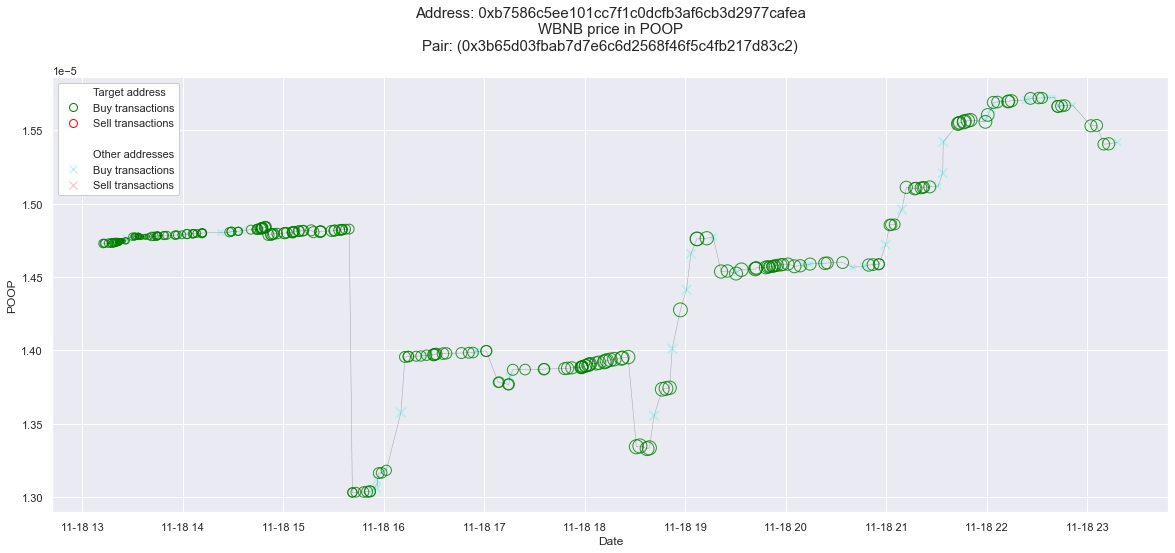

296


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0xb7586c5ee101cc7f1c0dcfb3af6cb3d2977cafea,is_buying
94191,0x3b65d03fbab7d7e6c6d2568f46f5c4fb217d83c2,0x00000000000000000000000000000000000000000000...,23165845,0x19ffcb113946a08a017ae3463c9712b30ab4675bdd28...,1668787822,5000000000,176536,202,0x4ce857155d0ab7ab36fdbca5249c9105f15569a58033...,76,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x812c7f24ba3647a01d61be68d8b5f9c9062a2ee9,2022-11-18 16:10:22,0,15190000000000000000,1118816001077966,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.000014,73654.772948,63.719862,False,True
167742,0x3b65d03fbab7d7e6c6d2568f46f5c4fb217d83c2,0x00000000000000000000000000000000000000000000...,23168829,0x7b29e87382b5065bf6657df0b2220bbee61df1069c2e...,1668796888,5000000000,157411,188,0x4cb1845ea01f4934ea8155cd9797f7fb157542e0b954...,96,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x38c7d36cd4c021d06598acb93f537fc2772e7f6f,2022-11-18 18:41:28,0,8300000000000000000,612289941926545,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.000014,73769.872521,62.847923,False,True
171598,0x3b65d03fbab7d7e6c6d2568f46f5c4fb217d83c2,0x00000000000000000000000000000000000000000000...,23169045,0x2df9e89b985e9181ba333628dbb3752331c4eb43a8d2...,1668797536,5000000000,157411,150,0x438a32ffe4b5df57781898e4f9edbc149152a26f84d6...,58,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xe32952d2ed11cac9a70cde455d35e8dd25ed0fba,2022-11-18 18:52:16,0,10000000000000000000,713669747494645,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.000014,71366.974749,63.116737,False,True
174490,0x3b65d03fbab7d7e6c6d2568f46f5c4fb217d83c2,0x00000000000000000000000000000000000000000000...,23169215,0x9a020da2a28b37684cac48ff15b969e2e21a799f6563...,1668798046,5000000000,157411,65,0xd49d03cf8c63b2c7e16bb31ab04ecaba44415fe4cc1e...,35,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xe32952d2ed11cac9a70cde455d35e8dd25ed0fba,2022-11-18 19:00:46,0,5000000000000000000,346897242133035,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.000014,69379.448427,62.116734,False,True
175558,0x3b65d03fbab7d7e6c6d2568f46f5c4fb217d83c2,0x00000000000000000000000000000000000000000000...,23169268,0x7bb019e40c8e123c52aad0fa03ed2e502c89cae3155a...,1668798205,5000000000,157399,52,0x7025a8fc193f0f3fadb1931f0058ad9669d97e706080...,40,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xe32952d2ed11cac9a70cde455d35e8dd25ed0fba,2022-11-18 19:03:25,0,4000000000000000000,272875497491944,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.000015,68218.874373,61.794804,False,True
209686,0x3b65d03fbab7d7e6c6d2568f46f5c4fb217d83c2,0x00000000000000000000000000000000000000000000...,23171576,0xa4a78efad0ea7df5ba53e740809377a7723d0e8b706f...,1668805181,6000000000,221278,33,0x94f1828aecde1682fcfde9b8063fe0c300263c315586...,12,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x8026e270ca4156886ea1717f9d1fa299948079f0,2022-11-18 20:59:41,0,4813737998853841151,327014442182077,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.000015,67933.577245,62.061961,False,True
212520,0x3b65d03fbab7d7e6c6d2568f46f5c4fb217d83c2,0x00000000000000000000000000000000000000000000...,23171770,0x8f89171e447ac91885694c1bf17b8b69e8773b978d0a...,1668805763,5000000000,157411,223

287
54.76164031495035
0.9999256916400318
57.87698615084267
2.999625038175685


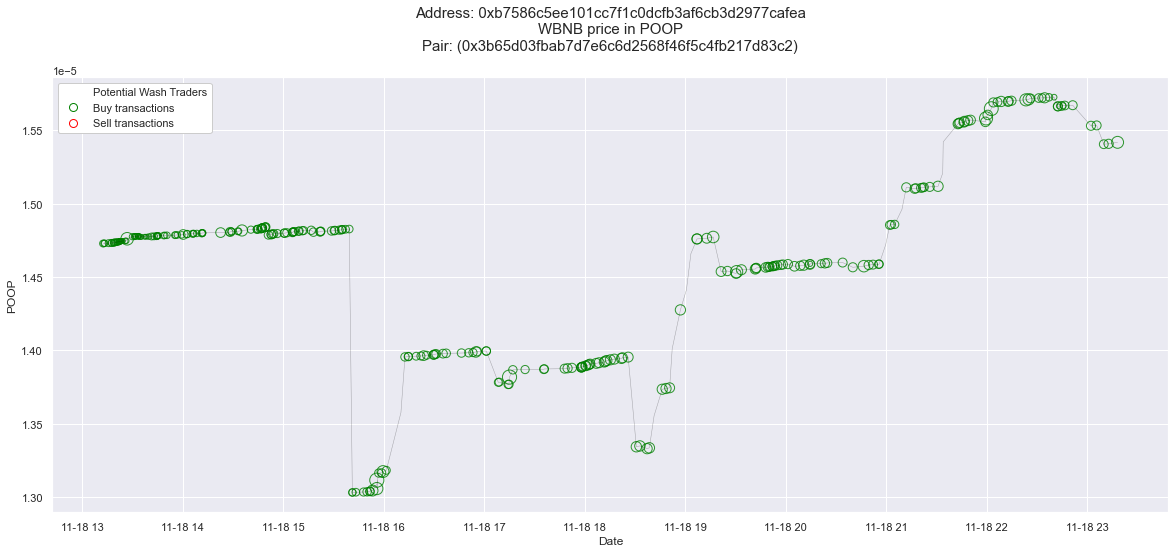

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0xb7586c5ee101cc7f1c0dcfb3af6cb3d2977cafea,is_buying
66,0x3b65d03fbab7d7e6c6d2568f46f5c4fb217d83c2,0x00000000000000000000000000000000000000000000...,23162343,0xd164f8b48ffd5e67fd250a3ae0486f2649fcf11766fa...,1668777155,5000000000,1133329,473,0xccc47029f6ee7ac410f56270d1a17e52bc12fe21ba8c...,139,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xb7586c5ee101cc7f1c0dcfb3af6cb3d2977cafea,2022-11-18 13:12:35,0,16950006980624553,1150867493358,0,0.4636,253.0,9.0,9.617185e+18,0.023715,True,0x3b65d03fbab7d7e6c6d2568f46f5c4fb217d83c2,-2.925393e+13,-4.057454e+17,0,9616520620378558054,9616520620378558054,664089785540994,0,664089785540994,1.434132e-12,1.915343e-17,True,0.000015,67897.759256,53.912233,True,True
413,0x3b65d03fbab7d7e6c6d2568f46f5c4fb217d83c2,0x00000000000000000000000000000000000000000000...,23162355,0x244e518af969a2427ae0adf58b2c812fc196cb3286e8...,1668777191,5000000000,1148317,329,0xaeb3a83649e1d3c2e3b7ffdf0254ae439af7f46460e1...,129,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xb7586c5ee101cc7f1c0dcfb3af6cb3d2977cafea,2022-11-18 13:13:11,0,15236463122381120,1034459599700,0,0.4636,253.0,9.0,9.617185e+18,0.023715,True,0x3b65d03fbab7d7e6c6d2568f46f5c4fb217d83c2,-2.925393e+13,-4.057454e+17,0,9616520620378558054,9616520620378558054,664089785540994,0,664089785540994,1.434132e-12,1.915343e-17,True,0.000015,67893.683159,53.758476,True,True
611,0x3b65d03fbab7d7e6c6d2568f46f5c4fb217d83c2,0x00000000000000000000000000000000000000000000...,23162362,0xaaf2842022f13dcd0281746c992086b5b586aa096364...,1668777212,5000000000,1102650,311,0xd5bed990f74d159896e2a22f4a634dd4f98987090685...,142,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xb7586c5ee101cc7f1c0dcfb3af6cb3d2977cafea,2022-11-18 13:13:32,0,13981787654467844,949223330710,0,0.4636,253.0,9.0,9.617185e+18,0.023715,True,0x3b65d03fbab7d7e6c6d2568f46f5c4fb217d83c2,-2.925393e+13,-4.057454e+17,0,9616520620378558054,9616520620378558054,664089785540994,0,664089785540994,1.434132e-12,1.915343e-17,True,0.000015,67889.983325,53.634496,True,True
1925,0x3b65d03fbab7d7e6c6d2568f46f5c4fb217d83c2,0x00000000000000000000000000000000000000000000...,23162410,0x97d068ec7ae45ee05b450f2d9f2cdd4fd3624d75d777...,1668777356,7000000000,1125432,31,0x699767b98f0848232517a20b1f1b19617248f374619a...,30,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xb7586c5ee101cc7f1c0dcfb3af6cb3d2977cafea,2022-11-18 13:15:56,0,17085876802737144,1159892692840,0,0.4636,253.0,9.0,9.617185e+18,0.023715,True,0x3b65d03fbab7d7e6c6d2568f46f5c4fb217d83c2,-2.925393e+13,-4.057454e+17,0,9616520620378558054,9616520620378558054,664089785540994,0,664089785540994,1.434132e-12,1.915343e-17,True,0.000015,67886.050346,53.923752,True,True
3468,0x3b65d03fbab7d7e6c6d2568f46f5c4fb217d83c2,0x00000000000000000000000000000000000000000000...,23162446,0xb293cbe3a3412479488b21733863d20ecdbfdcb15792...,1668777464,5000000000,1129480,448,0xb453ea9b60586e9bdccb143dd3fa684c0437bff2ded9...,161,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xb7586c5ee101cc7f1c0dcfb3af6cb3d2977cafea,2022-11-18 13:17:44,0,17995222966538732,1221544694438,0,0.4636,253.0,9.0,9.617185e+18,0.023715,True,0x3b65d03fbab7d7e6c6d2568f46f5c4fb217d83c2,-2.925393e+13,-4.057454e+17,0,9616520620378558054,9616520620378558054,664089785540994,0,664089785540994,1.434132e-12,1.915343e-17,True,0.000015,67881.609286,53.998561,True,

Swapper address: 0x8b8278b399755c8a1118a61e09efaac75ecd7f9e


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
8,1.21,True,False,True,0.19,NaN,NaN,-106.625887,NaN,NaN,NaN,6.332493e+22,NaN,NaN,NaN,258.469119,NaN


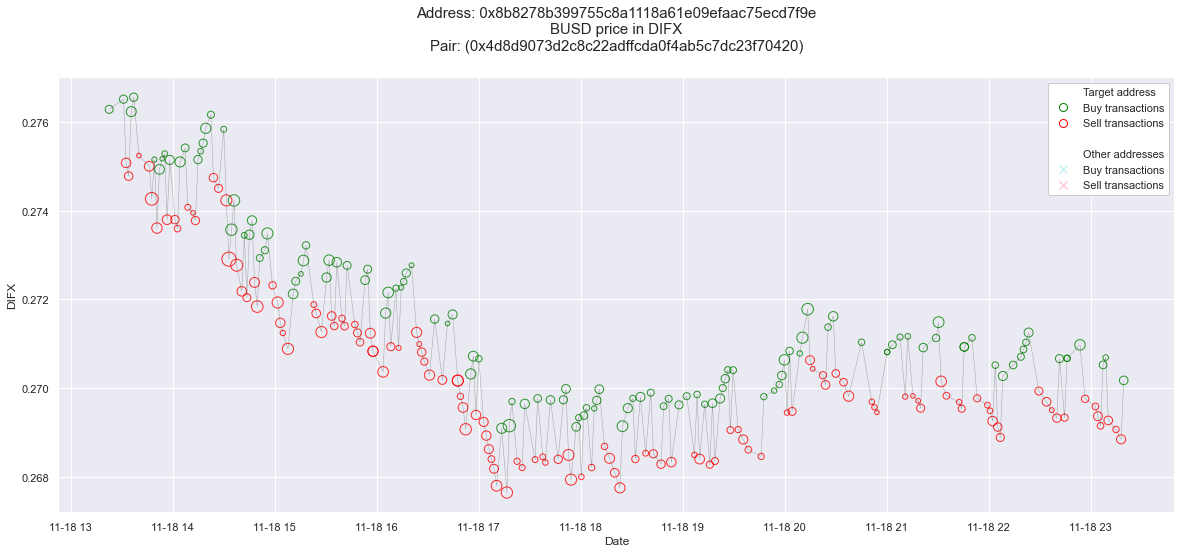

245


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x8b8278b399755c8a1118a61e09efaac75ecd7f9e,is_buying
44531,0x4d8d9073d2c8c22adffcda0f4ab5c7dc23f70420,0x00000000000000000000000000000000000000000000...,23163952,0xff4eaa3dda4cb1abecbe15adada7bbe126af2242c607...,1668781982,8000000000,119843,17,0x6471dcf42dd7260262720dc79d5da874b9d9cc3df87f...,11,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x8b8278b399755c8a1118a61e09efaac75ecd7f9e,2022-11-18 14:33:02,7151000000000000000000,0,0,1951565462765503222096,0.449,245.0,0.0,1.210164,0.187755,True,0x4d8d9073d2c8c22adffcda0f4ab5c7dc23f70420,-5.764292e+20,-1.570398e+20,34622934252573567105612,28702000000000000000000,63324934252573567105612,105625223996327574143772,127935000000000000000000,233560223996327574143772,9.443783e-09,6.736258e-09,True,0.272908,3.664238,72.946763,True,False


244
69.8109591769862
0.7582138145761295
nan
nan


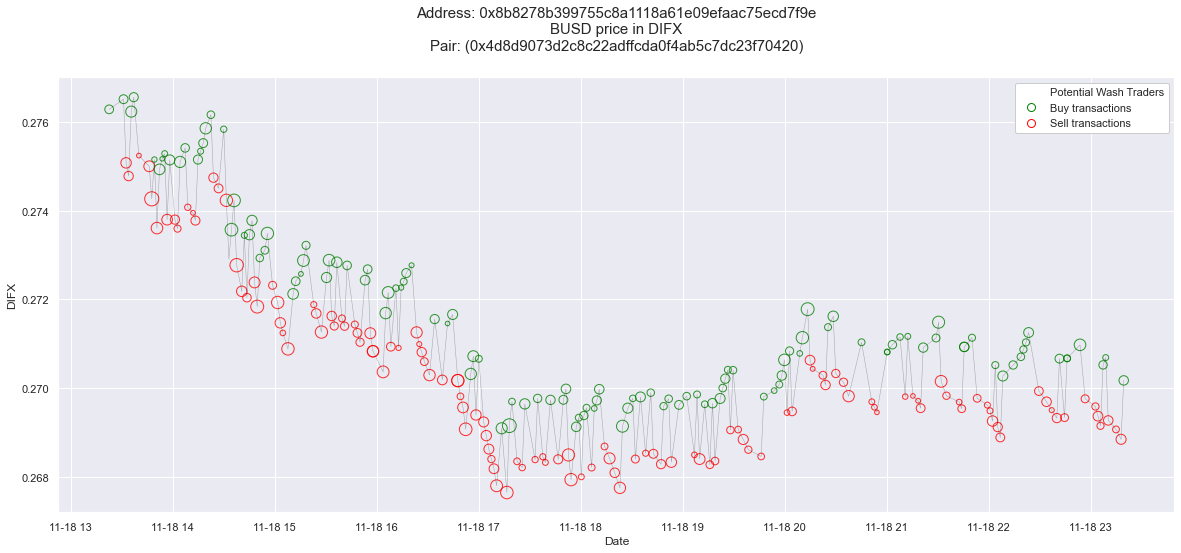

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x8b8278b399755c8a1118a61e09efaac75ecd7f9e,is_buying
6413,0x4d8d9073d2c8c22adffcda0f4ab5c7dc23f70420,0x00000000000000000000000000000000000000000000...,23162543,0xb244bde1c75b408b7c6ac284dbfc015f29e2db76c0b8...,1668777755,5000000000,119932,160,0xae692237f53fa46dc85b932a84316c38bd905cb768b5...,53,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x8b8278b399755c8a1118a61e09efaac75ecd7f9e,2022-11-18 13:22:35,0,211000000000000000000,763705075619611450155,0,0.449,245.0,0.0,1.210164,0.187755,True,0x4d8d9073d2c8c22adffcda0f4ab5c7dc23f70420,-5.764292e+20,-1.570398e+20,34622934252573567105612,28702000000000000000000,63324934252573567105612,105625223996327574143772,127935000000000000000000,233560223996327574143772,9.443783e-09,6.736258e-09,True,0.276285,3.619455,69.723528,True,True
11263,0x4d8d9073d2c8c22adffcda0f4ab5c7dc23f70420,0x00000000000000000000000000000000000000000000...,23162712,0x3d44d6d1ef92b1f8bb29ff65dac168486a4626d2ce5a...,1668778262,5000000000,119932,456,0x799f9ab789bf91067a541bb69d2c133231d4de393821...,357,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x8b8278b399755c8a1118a61e09efaac75ecd7f9e,2022-11-18 13:31:02,0,219000000000000000000,792005928388555396819,0,0.449,245.0,0.0,1.210164,0.187755,True,0x4d8d9073d2c8c22adffcda0f4ab5c7dc23f70420,-5.764292e+20,-1.570398e+20,34622934252573567105612,28702000000000000000000,63324934252573567105612,105625223996327574143772,127935000000000000000000,233560223996327574143772,9.443783e-09,6.736258e-09,True,0.276513,3.616465,69.776281,True,True
12136,0x4d8d9073d2c8c22adffcda0f4ab5c7dc23f70420,0x00000000000000000000000000000000000000000000...,23162742,0xf780e7611ec562b8019a8140c548e80c436d8dd00887...,1668778352,8000000000,119831,29,0x386b7f098bd4ae51c2fdea5cfed750dedf562986d036...,20,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x8b8278b399755c8a1118a61e09efaac75ecd7f9e,2022-11-18 13:32:32,1166000000000000000000,0,0,320741388419160290928,0.449,245.0,0.0,1.210164,0.187755,True,0x4d8d9073d2c8c22adffcda0f4ab5c7dc23f70420,-5.764292e+20,-1.570398e+20,34622934252573567105612,28702000000000000000000,63324934252573567105612,105625223996327574143772,127935000000000000000000,233560223996327574143772,9.443783e-09,6.736258e-09,True,0.275078,3.635328,70.332644,True,False
12946,0x4d8d9073d2c8c22adffcda0f4ab5c7dc23f70420,0x00000000000000000000000000000000000000000000...,23162772,0x83561e6e0555860add3e69b5d73b07fcad94cf40466f...,1668778442,8000000000,119831,33,0x7cc10fa5758752736d8e22595afc3b6d841960eb9180...,14,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x8b8278b399755c8a1118a61e09efaac75ecd7f9e,2022-11-18 13:34:02,883000000000000000000,0,0,242630616850748514218,0.449,245.0,0.0,1.210164,0.187755,True,0x4d8d9073d2c8c22adffcda0f4ab5c7dc23f70420,-5.764292e+20,-1.570398e+20,34622934252573567105612,28702000000000000000000,63324934252573567105612,105625223996327574143772,127935000000000000000000,233560223996327574143772,9.443783e-09,6.736258e-09,True,0.274780,3.639277,69.931223,True,False
13791,0x4d8d9073d2c8c22adffcda0f4ab5c7dc23f70420,0x00000000000000000000000000000000000000000000...,23162803,0x809ea6adbcdb291708e9fbed64de30ed05707e14e4fc...,1668778535,5000000000,119920,132,0xf578dc84a3df552ed1c7aa62b0267af1d3dabc503f5b...,45,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x8b8278b399755c8a1118a61e09efaac75ecd7f9e,2022-11-18 13:35

Swapper address: 0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
9,1.12,True,False,True,0.0,NaN,NaN,NaN,-0.000381,NaN,NaN,NaN,1.722848e+17,NaN,NaN,NaN,0.000712


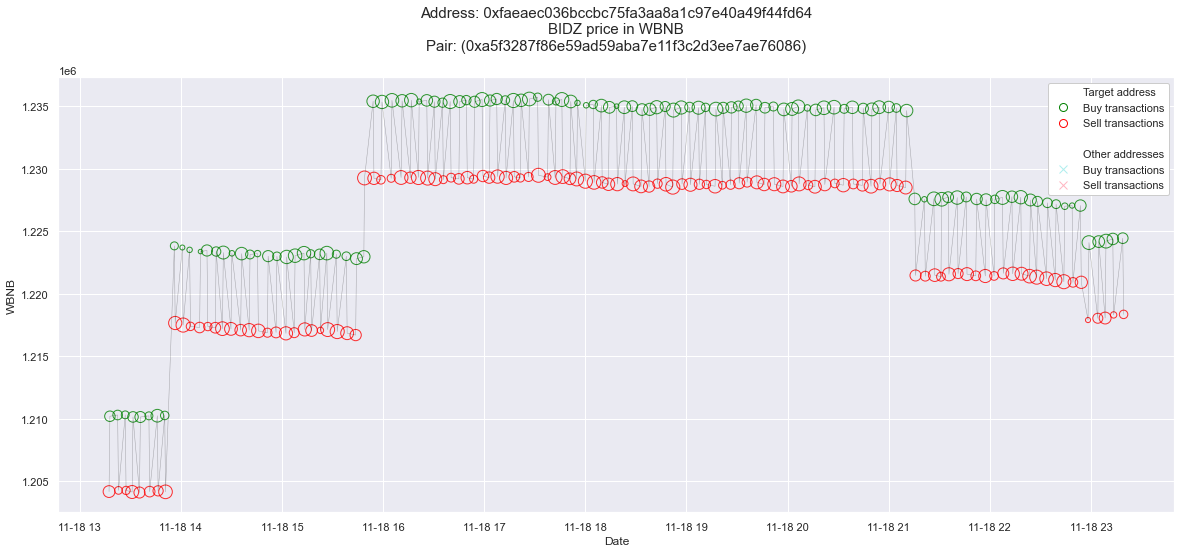

242


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64,is_buying


242
69.43696918570832
0.6320201395888418
nan
nan


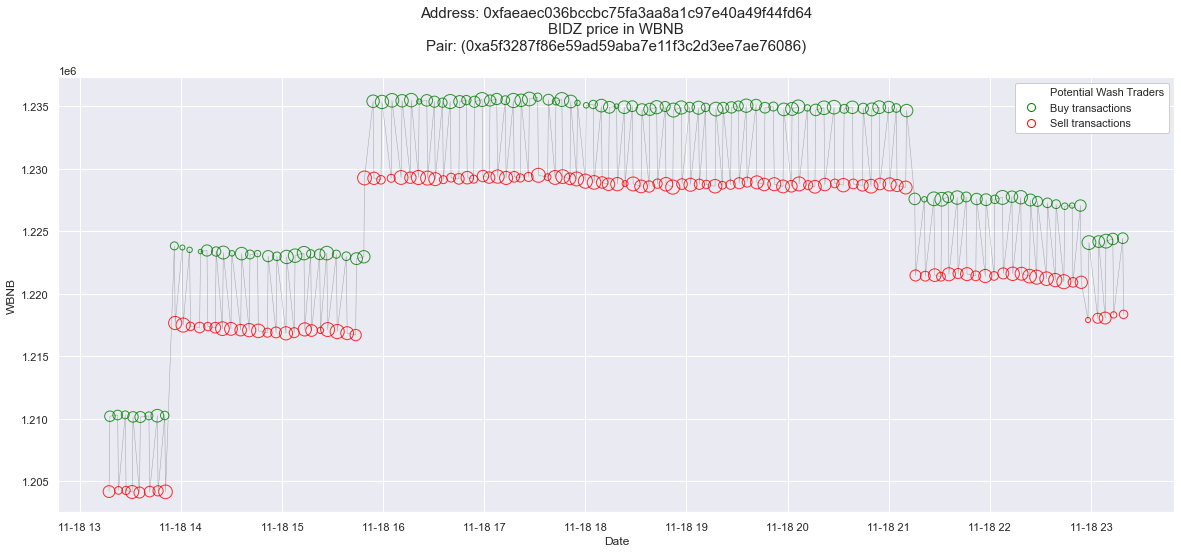

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64,is_buying
3284,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,0x00000000000000000000000000000000000000000000...,23162439,0xbf6876260176ad303296e6e7f04cabbf633d1bb71f47...,1668777443,5000000000,112923,265,0x21fa27bc74785595e98b967ec68a740db3e3133fa681...,97,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64,2022-11-18 13:17:23,726560457093211,0,0,874908368000000000000,0.4435,242.0,0.0,1.11717,0.0,True,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,-3.173209e+14,-3.840589e+20,111520726593000000000000,99824322742000000000000,211345049335000000000000,81151791107805038,91133030899728443,172284822007533481,3.151834e-08,4.968976e-15,True,1.204178e+06,8.304418e-07,69.567695,True,False
3533,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,0x00000000000000000000000000000000000000000000...,23162449,0x73fb8de7dbe4880eb7fae83357077ada72f56fe52237...,1668777473,5000000000,120461,82,0x33dab57a9c7819ebd29b02ae372e6a9428e3d4206fd7...,23,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64,2022-11-18 13:17:53,0,671576188000000000000,554927480628738,0,0.4435,242.0,0.0,1.11717,0.0,True,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,-3.173209e+14,-3.840589e+20,111520726593000000000000,99824322742000000000000,211345049335000000000000,81151791107805038,91133030899728443,172284822007533481,3.151834e-08,4.968976e-15,True,1.210205e+06,8.263061e-07,69.186114,True,True
6361,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,0x00000000000000000000000000000000000000000000...,23162541,0xaf22b743ee2084e4741c61e8ec39d3fa17027a66ce65...,1668777749,5000000000,120461,304,0xd37e9de5e20e1b1f43dae6719433934afa89488a3229...,122,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64,2022-11-18 13:22:29,0,574424897000000000000,474611741123923,0,0.4435,242.0,0.0,1.11717,0.0,True,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,-3.173209e+14,-3.840589e+20,111520726593000000000000,99824322742000000000000,211345049335000000000000,81151791107805038,91133030899728443,172284822007533481,3.151834e-08,4.968976e-15,True,1.210305e+06,8.262381e-07,68.960681,True,True
6621,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,0x00000000000000000000000000000000000000000000...,23162551,0x565c6dfdde965608c47ab5f134610b3bb97e51ec004f...,1668777779,5000000000,112935,266,0x1d5901418a7536e9257a36818cf145d123621d39d536...,116,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64,2022-11-18 13:22:59,357272907033042,0,0,430253892000000000000,0.4435,242.0,0.0,1.11717,0.0,True,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,-3.173209e+14,-3.840589e+20,111520726593000000000000,99824322742000000000000,211345049335000000000000,81151791107805038,91133030899728443,172284822007533481,3.151834e-08,4.968976e-15,True,1.204272e+06,8.303769e-07,68.543751,True,False
8787,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,0x00000000000000000000000000000000000000000000...,23162631,0x1fd84d2f05b43176bb4d101553438e8ae779d767da29...,1668778019,5000000000,120461,254,0x000d342595d5f3bc3aea7aead3120d77ed40c1f243b5...,128,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64,2022-11-18 13:26:59,0,438163634000000000000,362023906238263,0,0.4435,242.0,0.0,1.11717,0.0,True,0xa5f3


Identified 10 adresses as bots, 6 of which are contracts                                            


,swapper,hour_window,txs_from_address,percent_txs_from_address,txs_in_same_block,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,most_common_pair_address,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,total_token1_volume_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address
0,0x2aef87eb18cd692ef3c97be2a6eca6709e146bf1,10.116,1930.0,3.54,14.0,1.181799e+29,True,True,True,0xc4475f4584ed542585d5cc3c95a474b9e1cad3c9,0.02,NaN,NaN,NaN,7095.143589,NaN,NaN,NaN,5.886012,NaN,NaN,NaN,1.136000e+22,118179915701488549065569919278,11360003174999999989600,0.02,0.0
1,0x3b7676bd219d19358ccfaf8ce9f9675bde2ae4f7,9.060,601.0,1.10,457.0,4.327547e+20,True,True,True,0xa68417f6316fab6820ffc4ea91af90fe60a183db,0.01,69.275923,NaN,NaN,NaN,0.718889,NaN,NaN,NaN,4.320525e+20,NaN,NaN,NaN,702191707626061228,432052524590006762085,0.00,0.0
2,0x581478e4b12b7cf981dad77eda039a56cbfcc512,9.998,483.0,0.89,82.0,1.300000e+00,True,False,True,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,0.37,-1140.653142,NaN,NaN,NaN,131.318534,NaN,NaN,NaN,6.342685e+22,NaN,NaN,NaN,12444018814969952156099368,63426851897430934206632,0.00,0.0
3,0x5e26adac0eeb658381cff8e2f1188e648383dce0,9.798,421.0,0.77,15.0,7.454087e+21,True,True,True,0xc46c118b9a61cd238344fe8f7dbb3e9674c047a1,0.01,2470.927387,NaN,NaN,NaN,17.705667,NaN,NaN,NaN,7.454086e+21,NaN,NaN,NaN,1528076592431218,7454085669343285921509,0.00,0.0
4,0xba8c06be90fa46d634515716eae4ffc3a8bfc4cd,10.088,294.0,0.54,4.0,1.830000e+00,True,True,True,0x2fd1a7761d9cbadbefa188955ad85b9e40a38744,0.27,NaN,-700.330195,NaN,NaN,NaN,282.830717,NaN,NaN,NaN,8.315223e+22,NaN,NaN,83152230754661580824877,18458490266365923212139,0.00,0.0
5,0x6b4813b50c623da72470737b387cb0ff027429b6,10.071,259.0,0.47,0.0,6.088599e+20,True,True,False,0x352008bf4319c3b7b8794f1c2115b9aa18259ebb,0.01,NaN,NaN,NaN,-0.015746,NaN,NaN,NaN,0.540990,NaN,NaN,NaN,6.654182e+19,7298353529727729788239,7296482084009500997408,0.00,0.0
6,0x72080625314625d726d09ed340b97386c5e1fb9b,2.333,254.0,0.47,0.0,1.010000e+00,True,False,True,0x0c8140f02cedcf12bcccfccdd7d18a72327314dc,0.02,NaN,NaN,-87.679824,NaN,NaN,NaN,136.211058,NaN,NaN,NaN,3.459761e+22,NaN,34597608748376632981513,36381132707500300,0.00,0.0
7,0xb7586c5ee101cc7f1c0dcfb3af6cb3d2977cafea,10.002,253.0,0.46,9.0,9.617185e+18,True,True,True,0x3b65d03fbab7d7e6c6d2568f46f5c4fb217d83c2,0.02,NaN,NaN,NaN,0.615103,NaN,NaN,NaN,0.038010,NaN,NaN,NaN,9.616521e+18,9616520620378558054,664089785540994,0.00,0.0
8,0x8b8278b399755c8a1118a61e09efaac75ecd7f9e,9.948,245.0,0.45,0.0,1.210000e+00,True,False,True,0x4d8d9073d2c8c22adffcda0f4ab5c7dc23f70420,0.19,NaN,NaN,-106.625887,NaN,NaN,NaN,258.469119,NaN,NaN,NaN,6.332493e+22,NaN,63324934252573567105612,233560223996327574143772,0.00,0.0
9,0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64,10.033,242.0,0.44,0.0,1.120000e+00,True,False,True,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,0.00,NaN,NaN,NaN,-0.000381,NaN,NaN,NaN,0.000712,NaN,NaN,NaN,1.722848e+17,211345049335000000000000,172284822007533481,0.00,0.0


In [5]:
# Filter out top adresses by something: sort_values(by=[

# 1) To find most active bots, put:________________by=["percent_txs_from_address"]
# 2) To find predictable market makers, put:_______by=["tx_size_similarity"]
# 3) To find sandwitch bots, put:__________________by=["txs_in_same_block"]

x = df.drop_duplicates(subset = "To").round(2).sort_values(by = ["percent_txs_from_address"], ascending = False, kind = "mergesort").reset_index(drop = True)[:10] # only analyse top 20 addresses by percent_txs_from_address
# print(x.head())
# and check if they are contracts or simple addresses
def unique(sequence):
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

bot_list = unique([i for i in x.To.to_list() if i in set(x.To.to_list())]) # preserves order
# print(bot_list)

if len(bot_list) < 200:
    iteration = 0
    for bot in bot_list:
        iteration += 1
        print(f"Analysing top {len(bot_list)} bot addresses. {iteration} out of {len(bot_list)}...", end="\r")

        # check all their txs
        _df = df[df.To == bot] 
        most_common_pair_address = max(set(_df.contract_address.to_list()), key = _df.contract_address.to_list().count) 
        _df = _df[_df.contract_address == most_common_pair_address] 
        # print(pair_info['token0_symbol'], pair_info['token1_symbol'])
        bot_is_contract = address_is_contract(bot, w3) # takes some time
        x.loc[x.To == bot, "address_is_contract"] = bot_is_contract 

        # check hour window that the transactions occurs
        hour_window = (_df.timeStamp.max() - _df.timeStamp.min()) / (60*60)
        x.loc[x.To == bot,"hour_window"] = round(hour_window, 3)

        pair_info = get_pair_info(most_common_pair_address, abi, bsc_scan_api_key, w3) # takes some time
        pair_info["signatures"] = signatures
        
        # Calculation of profits - do it here bcs need pair_info which takes too long to run for every address in df 
        # Get token price, which is simply a ratio of the Swap
        token0_price_in_token1 = pd.to_numeric((_df.amount1In + _df.amount1Out) / (_df.amount0In + _df.amount0Out)) * (10**(pair_info["token0_decimals"] - pair_info["token1_decimals"])) # accounting for token decimals shown in contract
        # _df["token0_price_in_token1"] = token0_price_in_token1
        token1_price_in_token0 = 1 / token0_price_in_token1
        # _df["token1_price_in_token0"] = token1_price_in_token0
        
        # Get current accumulated position
        position_token0 = (_df.amount0Out.sum() - _df.amount0In.sum()) * 10** - pair_info["token0_decimals"]
        position_token1 = (_df.amount1Out.sum() - _df.amount1In.sum()) * 10** - pair_info["token1_decimals"]
        # Get profits in terms of token0 and token1 
        address_position_token0 = position_token0 + (position_token1 * token1_price_in_token0.iloc[-1]) # token1_price_in_token0 is series - take only last item!
        address_position_token1 = position_token1 + (position_token0 * token0_price_in_token1.iloc[-1])

        #Get volume of the token0 and token1
        token0_volume = (_df.amount0Out.sum() + _df.amount0In.sum())
        token1_volume = (_df.amount1Out.sum() + _df.amount1In.sum())
        


        for i in ["USDT", "USDC", "BUSD", "WBNB"]:
            x.loc[x.To == bot, f"profit_in_{i}"] = np.nan # default value
            x.loc[x.To == bot, f"mean_tx_size_in_{i}"] = np.nan # default value
            x.loc[x.To == bot, f"volume_in_{i}"] = np.nan # default value

        # When need to know what is the reference coin:
        if pair_info['token0_symbol'] in ["USDT", "USDC", "BUSD", "WBNB"]:
            # show profit in reference token
            x.loc[x.To == bot, f"profit_in_{pair_info['token0_symbol']}"] = address_position_token0

            # check mean swap size in reference token:
            x.loc[x.To == bot, f"mean_tx_size_in_{pair_info['token0_symbol']}"] = (_df.amount0Out.sum() + _df.amount0In.sum())* 10**-pair_info["token0_decimals"] / len(_df)

            # show volume in reference token
            x.loc[x.To == bot, f"volume_in_{pair_info['token0_symbol']}"] = token0_volume

        elif pair_info['token1_symbol'] in ["USDT", "USDC", "BUSD", "WBNB"]:
            # show profit in reference token
            x.loc[x.To == bot, f"profit_in_{pair_info['token1_symbol']}"] = address_position_token1

            # check mean swap size in reference token:
            x.loc[x.To == bot, f"mean_tx_size_in_{pair_info['token1_symbol']}"] = (_df.amount1Out.sum() + _df.amount1In.sum())* 10**-pair_info["token1_decimals"] / len(_df)

            # show volume in reference token
            x.loc[x.To == bot, f"volume_in_{pair_info['token1_symbol']}"] = token1_volume
        
        else:
            print()
            print(f"There is no reference coin in pair {most_common_pair_address}? {pair_info['token0_symbol']} vs {pair_info['token1_symbol']}")
        
        if bot_is_contract:
            print(f"Swapper contract: {bot}")

        else:
            print(f"Swapper address: {bot}")

        # print(f"Pair contract address: {most_common_pair_address}")
        
        display(x.loc[x.To == bot][[
            "position_ratio",
            "potential_wash_trading_bot",
            "address_is_contract",
            "focused_on_single_pair",
            "tx_size_similarity",
            # "USDT",
            # "BUSD",
            # "WBNB",
            "profit_in_USDT",
            "profit_in_USDC",
            "profit_in_BUSD",
            "profit_in_WBNB",
            "volume_in_USDT",
            "volume_in_USDC",
            "volume_in_BUSD",
            "volume_in_WBNB",
            "mean_tx_size_in_USDT",
            "mean_tx_size_in_USDC",
            "mean_tx_size_in_BUSD",
            "mean_tx_size_in_WBNB"]])

        wash_trading = x.loc[x.To == bot, "potential_wash_trading_bot"]

        plot_address_txs(df, bot, pair_info)
        
        if wash_trading.iat[0]:
            find_other_txs_and_analyze_them(df, bot, pair_info)
        # display(df.head(10))
        # break
        # print()

# # Identify potential sandwitch bots based on having any txs_in_same_block and having very balanced position (always buys and sells immediately)
# x["potential_sandwitch_bot"] = False
# x.loc[(x.txs_in_same_block>0) 
# & (x.position_ratio < 1.1)
# , "potential_sandwitch_bot"] = True

# should calculate profits differently if position is balanced.

contract_list = set(x[x.address_is_contract == True].To.to_list())
print()
print(" " * 100, end = "\r")
print(f"Identified {len(bot_list)} adresses as bots, {len(contract_list)} of which are contracts")

x[
["To",
"hour_window",
"txs_from_address",
"percent_txs_from_address",
"txs_in_same_block",
"position_ratio",
"potential_wash_trading_bot",
"address_is_contract",
"focused_on_single_pair",
"most_common_pair_address",
"tx_size_similarity",
# "USDT",
# "BUSD",
# "WBNB",
"profit_in_USDT",
"profit_in_USDC",
"profit_in_BUSD",
"profit_in_WBNB",
"mean_tx_size_in_USDT",
"mean_tx_size_in_USDC",
"mean_tx_size_in_BUSD",
"mean_tx_size_in_WBNB",
"volume_in_USDT",
"volume_in_USDC",
"volume_in_BUSD",
"volume_in_WBNB",
"total_token1_volume_by_address",
"total_token0_volume_by_address",
"percent_token1_volume_by_address",
"percent_token0_volume_by_address",
# "to_address_is_contract",
# "to_address_is_bot",
# "Txhash"
# "profit_in_token0",
# "profit_in_token1"
]].rename(columns = {"To": "swapper"})

## Check address or pair on websites

In [ ]:
# DEX TOOLS

pair_address = "0xe79792f57feb774c98b9c0ae3879e94151bbc6fd"
# open pair in dextools
browser=webbrowser.open(f"https://www.dextools.io/app/bnb/pair-explorer/{pair_address}")

In [ ]:
# BSC SCAN

# for address in x.To.to_list():
address = "0x8b8278b399755c8a1118a61e09efaac75ecd7f9e"
browser=webbrowser.open(f"https://bscscan.com/address/{address}#tokentxns")